In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import pickle
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
os.listdir('../input/lish-moa')

['test_features.csv',
 'train_drug.csv',
 'train_features.csv',
 'train_targets_scored.csv',
 'train_targets_nonscored.csv',
 'sample_submission.csv']

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
train_drug = pd.read_csv('../input/lish-moa/train_drug.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]
predictors = GENES+CELLS

In [5]:
train_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371


In [6]:
train_targets_scored.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_targets_nonscored.head(2)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.151,-0.775
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.381,-0.730


In [9]:
sample_submission.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [10]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASSED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## preprocess data

In [11]:
def drop_ctl_vehicle(train_features, test_features):
    
    train_features = train_features[train_features['cp_type'] != 'ctl_vehicle']
    test_features = test_features[test_features['cp_type'] != 'ctl_vehicle']
    target = train_targets_scored.iloc[train_features.index]
    train_features.reset_index(drop=True, inplace=True)
    test_features.reset_index(drop=True, inplace=True)
    
    return train_features, test_features, target

# train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
# test_features

In [12]:
def rank_gauss(train_features, test_features):
    
    train_features_ = train_features.copy()
    test_features_ = test_features.copy()
    
    GENES = [col for col in train_features_.columns if col.startswith('g-')]
    CELLS = [col for col in train_features_.columns if col.startswith('c-')]
    
    for col in (GENES + CELLS):

        transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
        vec_len = len(train_features_[col].values)
        vec_len_test = len(test_features_[col].values)
        raw_vec = train_features_[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)

        train_features_[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
        test_features_[col] = transformer.transform(test_features_[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
        
    return train_features_, test_features_

# train_features1, test_features1 = rank_gauss(train_features, test_features)
# train_features1

In [13]:
def get_stats(train_features, test_features):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    for df in [train_features, test_features]:
#         df['g_sum'] = df[GENES].sum(axis = 1)
        df['g_mean'] = df[GENES].mean(axis = 1)
        df['g_std'] = df[GENES].std(axis = 1)
        df['g_kurt'] = df[GENES].kurtosis(axis = 1)
        df['g_skew'] = df[GENES].skew(axis = 1)
#         df['g_max'] = df[GENES].max(axis=1)
#         df['g_min'] = df[GENES].max(axis=1)
#         df['c_sum'] = df[CELLS].sum(axis=1)
        df['c_mean'] = df[CELLS].mean(axis = 1)
        df['c_std'] = df[CELLS].std(axis = 1)
        df['c_kurt'] = df[CELLS].kurtosis(axis = 1)
        df['c_skew'] = df[CELLS].skew(axis = 1)
#         df['c_max'] = df[CELLS].max(axis=1)
#         df['c_min'] = df[CELLS].min(axis=1)
#         df['gc_sum'] = df[GENES + CELLS].sum(axis = 1)
        df['gc_mean'] = df[GENES + CELLS].mean(axis = 1)
        df['gc_std'] = df[GENES + CELLS].std(axis = 1)
        df['gc_kurt'] = df[GENES + CELLS].kurtosis(axis = 1)
        df['gc_skew'] = df[GENES + CELLS].skew(axis = 1)
        
    return train_features, test_features

# train_features, test_features = get_stats(train_features, test_features)
# test_features

In [14]:
def get_pca(train_features, test_features, n_gs, n_cs):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    pca_gs = PCA(n_components = n_gs)
    pca_cs = PCA(n_components = n_cs)
    
    train_pca_gs = pca_gs.fit_transform(train_features[GENES])
    train_pca_cs = pca_cs.fit_transform(train_features[CELLS])
    test_pca_gs = pca_gs.transform(test_features[GENES])
    test_pca_cs = pca_cs.transform(test_features[CELLS])
    
    train_pca_gs = pd.DataFrame(train_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    train_pca_cs = pd.DataFrame(train_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    test_pca_gs = pd.DataFrame(test_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    test_pca_cs = pd.DataFrame(test_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    
    train_features = pd.concat([train_features, train_pca_gs, train_pca_cs], axis=1)
    test_features = pd.concat([test_features, test_pca_gs, test_pca_cs], axis=1)
    
    return train_features, test_features

# train_features, test_features = get_pca(train_features, test_features, n_gs=50, n_cs=15)
# test_features

In [15]:
def var_thresh(threshold, train_features, test_features):

    cols_numeric = [f for f in train_features.columns if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]
    mask = (train_features[cols_numeric].var() >= 0.8).values
    train_features_ = train_features[cols_numeric].loc[:, mask]
    test_features_ = test_features[cols_numeric].loc[:, mask]
    train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1).reset_index(drop=True)
    test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1).reset_index(drop=True)

    return train_features, test_features

# train_features, test_features = var_thresh_2(threshold=0.2, train_features=train_features, test_features=test_features)
# test_features

In [16]:
def get_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 0):
    
    GENES = [col for col in train.columns if col.startswith('g-')]
    CELLS = [col for col in train.columns if col.startswith('c-')]
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        
        return train, test
    
    train, test = create_cluster(train, test, GENES, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, CELLS, kind = 'c', n_clusters = n_clusters_c)
    
    return train, test

# train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)

In [17]:
def scaling(train_features, test_features):
    
    scaler = RobustScaler()
    train_features_ = train_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1)
    columns_ = train_features_.columns
    train_features_numerical = scaler.fit_transform(train_features_)
    test_features_numerical = scaler.transform(test_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1))
    train_features_ = pd.DataFrame(train_features_numerical, columns=columns_)
    test_features_ = pd.DataFrame(test_features_numerical, columns=columns_)
    train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1)
    test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1)
    
    return train_features, test_features

# train_features, test_features = scaling(train_features, test_features)
# train_features

In [18]:
def make_folds(train, num_starts, num_splits):
    
    train_ = train.copy()
    folds = []

    # LOAD FILES
    train_feats = pd.read_csv('../input/lish-moa/train_features.csv')
    scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
    drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
    scored = scored.loc[train_feats['cp_type'] == 'trt_cp', :]
    drug = drug.loc[train_feats['cp_type'] == 'trt_cp', :]
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left') 

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[(vc <= 6) | (vc == 12) | (vc == 18)].index.sort_values()
    vc2 = vc.loc[(vc > 6) & (vc != 12) & (vc != 18)].index.sort_values()

    for seed in range(num_starts):

        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}; dct2 = {}
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop = True)
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        scored['fold'] = scored.drug_id.map(dct1)
        scored.loc[scored.fold.isna(),'fold'] =\
            scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
        scored.fold = scored.fold.astype('int8')
        folds.append(scored.fold.values)

        del scored['fold']
        
        for i in range(len(folds)):
            train_[f'seed{i}'] = folds[i]

    return train_

In [19]:
def make_folds_old(train, n_splits):
    
    folds = train.copy()

    mskf = MultilabelStratifiedKFold(n_splits)

    for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
        folds.loc[v_idx, 'kfold'] = int(f)

    folds['kfold'] = folds['kfold'].astype(int)
    
    return folds

In [20]:
def preprocessor(train_features, test_features, train_targets_scored, train_targets_nonscored):
    
#     # drop_ctl_vehicle
#     train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
#     print('drop_ctl_vehicle: done')
    
    # rank_gauss
    train_features, test_features = rank_gauss(train_features, test_features)
    print('rank_gauss: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # stats
    train_features, test_features = get_stats(train_features, test_features)
    print('get_stats: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # pca
    train_features, test_features = get_pca(train_features, test_features, n_gs=600, n_cs=50) 
    print('get_pca: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # var_thresh
    train_features, test_features = var_thresh(threshold=0.8, train_features=train_features, test_features=test_features)
    print('var_thresh: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
#     # clustering
#     train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)
#     print('get_clustering: done')
#     print('train_features.shape', train_features.shape)
#     print('test_features.shape', test_features.shape)
    
#     # Scaling
#     train_features, test_features = scaling(train_features, test_features)
#     print('scaling: done')  # ない方がいいかも。
    
    # data merge
    nonscored_cols = train_targets_nonscored.iloc[:, 1:].sum(axis=0).sort_values(ascending=False).index.tolist() # Moaが多い順にカラムを取得
    nonscored_cols = ['sig_id'] + nonscored_cols[:train_targets_scored.shape[1]-1]
    train_targets_nonscored = train_targets_nonscored[nonscored_cols] # MoAが多い順にnonscoredからscoredと同じ分だけ抜き取る
    
    train = train_features.merge(train_targets_scored, on='sig_id').merge(train_targets_nonscored, on='sig_id')
    train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
    test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

    target = train[train_targets_scored.columns]
    target_nonscored = train[train_targets_nonscored.columns]
    target_nonscored = target_nonscored.iloc[:, :target.shape[1]]
    
    train = train.drop('cp_type', axis=1)
    test = test.drop('cp_type', axis=1)
    
    return train, target, test, target_nonscored

train, target, test, target_nonscored = preprocessor(train_features, test_features, train_targets_scored, train_targets_nonscored)

rank_gauss: done
train_features.shape (23814, 876)
test_features.shape (3982, 876)
get_stats: done
train_features.shape (23814, 888)
test_features.shape (3982, 888)
get_pca: done
train_features.shape (23814, 1538)
test_features.shape (3982, 1538)
var_thresh: done
train_features.shape (23814, 1044)
test_features.shape (3982, 1044)


In [21]:
folds = make_folds_old(train, n_splits=5)

In [22]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
target_nonscored_cols = target_nonscored.drop('sig_id', axis=1).columns.values.tolist()
feature_cols = [c for c in pd.get_dummies(train, columns=['cp_time', 'cp_dose']).columns if (c not in target_cols) & (c not in target_nonscored_cols)]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id']]
len(feature_cols)

1045

### shape check

In [23]:
print(f'train.shape: {train.shape}')
print(f'folds.shape: {folds.shape}')
print(f'test.shape: {test.shape}')
print(f'target.shape: {target.shape}')
print(f'target_nonscored.shape: {target_nonscored.shape}')
print(f'sample_submission.shape: {sample_submission.shape}')

train.shape: (21948, 1455)
folds.shape: (21948, 1456)
test.shape: (3624, 1043)
target.shape: (21948, 207)
target_nonscored.shape: (21948, 207)
sample_submission.shape: (3982, 207)


In [24]:
all_data = {
    'train': train, 
    'folds': folds, 
    'test': test, 
    'target': target, 
    'target_nonscored': target_nonscored, 
    'sample_submission': sample_submission
}

In [25]:
with open('all_data_ResNet.pickle', 'wb') as f:
    pickle.dump(all_data, f)

## Dataset Classes

In [26]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float), 
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

### training function

In [27]:
def train_fn(model, optimizer, scheduler, loss_tr, loss_fn, dataloader, device):
    rejected = 0
    model.train()
    final_loss = 0
    final_metric = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        if len(inputs) > 1: 
            inputs1 = inputs[:, :-len(predictors)]
            inputs2 = inputs[:, -len(predictors):]
            outputs = model(inputs1, inputs2)
            loss = loss_tr(outputs, targets)
            metric = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
            final_loss += loss.item()
            final_metric += metric.item()
            
        else:
            rejected += len(inputs)
        
    final_loss /= (len(dataloader) - rejected)
    final_metric /= (len(dataloader) - rejected)
    
    return final_loss, final_metric

In [28]:
def valid_fn(model, loss_tr, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    final_metric = 0
    valid_preds = []
    
    for data in dataloader:
        
        inputs, targets = data['x'].to(device), data['y'].to(device)
        inputs1 = inputs[:, :-len(predictors)]
        inputs2 = inputs[:, -len(predictors):]
        outputs = model(inputs1, inputs2)
        loss = loss_tr(outputs, targets)
        metric = loss_fn(outputs, targets)
        final_loss += loss.item()
        final_metric += metric.item()
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)
        valid_preds.append(outputs.numpy())
        
    final_loss /= len(dataloader)
    final_metric /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
        
    return final_loss, final_metric, valid_preds

In [29]:
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)
        inputs1 = inputs[:, :-len(predictors)]
        inputs2 = inputs[:, -len(predictors):]
        
        with torch.no_grad():
            outputs = model(inputs1, inputs2)
            
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)    
        preds.append(outputs.numpy())
        
    preds = np.concatenate(preds)
        
    return preds

### loss_function

In [30]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets, n_classes, smoothing=0.0):
        assert 0 <= smoothing <= 1
        with torch.no_grad():
            targets = targets * (1 - smoothing) + torch.ones_like(targets).to(DEVICE) * smoothing / n_classes
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss()._smooth(targets, inputs.shape[1], self.smoothing)

        if self.weight is not None:
            inputs = inputs * self.weight.unsqueeze(0)

        loss = F.binary_cross_entropy_with_logits(inputs, targets)

        return loss

In [31]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets
    
    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

### HyperParameters

In [32]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 35
BATCH_SIZE = 128
BATCH_SIZE_nonscored = 512
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False
EARLY_STOPPING_STEPS_nonscored = 4
EARLY_STOP_nonscored = True
smoothing = 0.001
p_min = smoothing
p_max = 1 - smoothing

num_features_1 = len(feature_cols)
num_features_2 = len(predictors)
num_targets = len(target_cols)
hidden_1 = 256
hidden_2 = 256

### Model

In [33]:
class Model_ResNet(nn.Module):
    def __init__(self, num_features_1, num_features_2, num_targets, hidden_1, hidden_2):
        super(Model_ResNet, self).__init__()
        
        self.batchnorm1_1 = nn.BatchNorm1d(num_features_1)
        self.dropout1_1 = nn.Dropout(0.3)
        self.Linear1_1 = nn.Linear(num_features_1, hidden_1)
        self.relu1_1 = nn.ReLU()
        self.batchnorm1_2 = nn.BatchNorm1d(hidden_1)
        self.Linear1_2 = nn.Linear(hidden_1, hidden_2)
        self.relu1_2 = nn.ReLU()
        
        self.batchnorm2_1 = nn.BatchNorm1d(num_features_2+hidden_2)
        self.dropout2_1 = nn.Dropout(0.3)
        self.Linear2_1 = nn.Linear(num_features_2+hidden_2, hidden_1)
        self.relu2_1 = nn.ReLU()
        self.batchnorm2_2 = nn.BatchNorm1d(hidden_1)
        self.Linear2_2 = nn.Linear(hidden_1, hidden_1)
        self.relu2_2 = nn.ReLU()
        self.batchnorm2_3 = nn.BatchNorm1d(hidden_1)
        self.Linear2_3 = nn.Linear(hidden_1, hidden_2)
        self.relu2_3 = nn.ReLU()
        
        self.batchnorm3_1 = nn.BatchNorm1d(hidden_2)
        self.Linear3_1 = nn.Linear(hidden_2, hidden_2)
        self.relu3_1 = nn.ReLU()
        self.batchnorm3_2 = nn.BatchNorm1d(hidden_2) 
        self.Linear3_2 = nn.Linear(hidden_2, num_targets)
        
        
        
    def recalibrate_layer(self, layer):

        if(torch.isnan(layer.weight_v).sum() > 0):
            print ('recalibrate layer.weight_v')
            layer.weight_v = torch.nn.Parameter(torch.where(torch.isnan(layer.weight_v), torch.zeros_like(layer.weight_v), layer.weight_v))
            layer.weight_v = torch.nn.Parameter(layer.weight_v + 1e-7)

        if(torch.isnan(layer.weight).sum() > 0):
            print ('recalibrate layer.weight')
            layer.weight = torch.where(torch.isnan(layer.weight), torch.zeros_like(layer.weight), layer.weight)
            layer.weight += 1e-7
            
    def forward(self, x_1, x_2):
        
        input_1 = x_1
        input_2 = x_2
        
        input_3 = self.batchnorm1_1(input_1)
        input_3 = self.dropout1_1(input_3)
        input_3 = self.Linear1_1(input_3)
        input_3 = self.relu1_1(input_3)
        input_3 = self.batchnorm1_2(input_3)
        input_3 = self.Linear1_2(input_3)
        input_3 = self.relu1_2(input_3)
        
        input_3_concat = torch.cat([input_2, input_3], axis=1)
        
        input_4 = self.batchnorm2_1(input_3_concat)
        input_4 = self.dropout2_1(input_4)
        input_4 = self.Linear2_1(input_4)
        input_4 = self.relu2_1(input_4)
        input_4 = self.batchnorm2_2(input_4)
        input_4 = self.Linear2_2(input_4)
        input_4 = self.relu2_2(input_4)
        input_4 = self.batchnorm2_3(input_4)
        input_4 = self.Linear2_3(input_4)
        input_4 = self.relu2_3(input_4)
        
        input_4_avg = (input_3 + input_4) * 0.5
        
        output = self.batchnorm3_1(input_4_avg)
        output = self.Linear3_1(output)
        output = self.relu3_1(output)
        output = self.batchnorm3_2(output)
        output = self.Linear3_2(output)
        
        return output

### Single fold training

In [34]:
def run_training(fold, seed, EPOCHS, LEARNING_RATE):
    
    print(f'==========FOLD{fold+1}==========')
    
    
    seed_everything(seed)
    
    train_losses = list()
    valid_losses = list()
    train_losses_nonscored = list()
    valid_losses_nonscored = list()
    
    train = pd.get_dummies(folds, columns=['cp_time', 'cp_dose'])
    test_ = pd.get_dummies(test, columns=['cp_time', 'cp_dose'])
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index()
    valid_df = train[train['kfold'] == fold].reset_index()
    
    x_train, y_train, y_train_nonscored = train_df[feature_cols].values, train_df[target_cols].values, train_df[target_nonscored_cols].values
    x_valid, y_valid, y_valid_nonscored = valid_df[feature_cols].values, valid_df[target_cols].values, valid_df[target_nonscored_cols].values
    
    x_train2 = train_df[predictors].values
    x_valid2 = valid_df[predictors].values
    
    x_train = np.concatenate([x_train, x_train2], axis=1)
    x_valid = np.concatenate([x_valid, x_valid2], axis=1)
    
    train_dataset = MoADataset(x_train, y_train)
    train_dataset_nonscored = MoADataset(x_train, y_train_nonscored)
    valid_dataset = MoADataset(x_valid, y_valid)
    valid_dataset_nonscored = MoADataset(x_valid, y_valid_nonscored)
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    trainloader_nonscored = torch.utils.data.DataLoader(train_dataset_nonscored, batch_size=BATCH_SIZE_nonscored, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    validloader_nonscored = torch.utils.data.DataLoader(valid_dataset_nonscored, batch_size=BATCH_SIZE_nonscored, shuffle=False)
    
    model = Model_ResNet(num_features_1=num_features_1,
                      num_features_2=num_features_2, 
                      num_targets=num_targets, 
                      hidden_1=hidden_1,
                      hidden_2=hidden_2)
    

    model.to(DEVICE)
    
    optimizer_nonscored = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler_nonscored = optim.lr_scheduler.OneCycleLR(optimizer=optimizer_nonscored, pct_start=0.3, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader_nonscored)) 
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing=smoothing)
    
    early_stoppping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    early_step_nonscored = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    print('nonscored-loop')
    
    for epoch in range(EPOCHS):
        
        print(f'-----EPOCH{epoch+1}-----')
        
        train_loss, train_metric = train_fn(model, optimizer_nonscored, scheduler_nonscored, loss_tr, loss_fn, trainloader_nonscored, DEVICE)
        print(f'train_loss: {train_loss:.5f}, train_metric: {train_metric:.5f}')
        train_losses_nonscored.append(train_metric)
        valid_loss, valid_metric, valid_preds = valid_fn(model, loss_tr, loss_fn, validloader_nonscored, DEVICE)
        print(f'valid_loss: {valid_loss:.5f}, valid_metric: {valid_metric:.5f}')
        valid_losses_nonscored.append(valid_metric)
        
        if valid_loss < best_loss:
            
            early_step_nonscored = 0
            best_loss = valid_loss
#             oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f'ResNet_FOLD{fold+1}_SEED{seed}.pth')
            
        elif(EARLY_STOP_nonscored == True):
            
            early_step_nonscored += 1
            if (early_step_nonscored >= EARLY_STOPPING_STEPS_nonscored):
                print('early_stopping')
                break
    
    plt.plot(train_losses_nonscored, label='train_losses')
    plt.plot(valid_losses_nonscored, label='valid_losses')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim([1e-3, 1e-2])
    plt.title(f'fold{fold+1} losses')
    plt.legend(loc='best')
    plt.show()
    
    
    model.load_state_dict(torch.load(f'ResNet_FOLD{fold+1}_SEED{seed}.pth'))
    model.Linear3_2 = nn.Linear(hidden_2, num_targets)
    model.to(DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.3, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader)) 
    
    best_loss = np.inf
    
    print('scored_loop')
    
    for epoch in range(EPOCHS):
        
        print(f'-----EPOCH{epoch+1}-----')
        
        train_loss, train_metric = train_fn(model, optimizer, scheduler, loss_tr, loss_fn, trainloader, DEVICE)
        print(f'train_loss: {train_loss:.5f}, train_metric: {train_metric:.5f}')
        train_losses.append(train_metric)
        valid_loss, valid_metric, valid_preds = valid_fn(model, loss_tr, loss_fn, validloader, DEVICE)
        print(f'valid_loss: {valid_loss:.5f}, valid_metric: {valid_metric:.5f}')
        valid_losses.append(valid_metric)
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f'ResNet_FOLD{fold+1}_SEED{seed}.pth')
            
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= EARLY_STOPPING_STEPS):
                break
                
    y_true = train_targets_scored[target_cols].values

    cv = 0
    for i in range(len(target_cols)):
        cv_ = log_loss(y_true[val_idx, i], oof[val_idx, i], labels=[0, 1])
        cv += cv_ / len(target_cols)
                
    plt.plot(train_losses, label='train_losses')
    plt.plot(valid_losses, label='valid_losses')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim([1e-2, 2e-2])
    plt.title(f'fold{fold+1} losses')
    plt.legend(loc='best')
    plt.show()
                
    #-----------------------PREDICTION-------------------------
                
    x_test = test_[feature_cols].values
    x_test2 = test_[predictors].values
    
    x_test = np.concatenate([x_test, x_test2], axis=1)
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model_ResNet(num_features_1=num_features_1,
                      num_features_2=num_features_2, 
                      num_targets=num_targets, 
                      hidden_1=hidden_1,
                      hidden_2=hidden_2)
    
    model.load_state_dict(torch.load(f'ResNet_FOLD{fold+1}_SEED{seed}.pth'))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions, cv

In [35]:
def run_k_fold(NFOLD, seed, EPOCH, LEARNING_RATE):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    CVs = list()
    
    for fold in range(NFOLDS):
        oof_, pred_, cv_ = run_training(fold, seed, EPOCH, LEARNING_RATE)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        CVs.append(cv_)
        
    return oof, predictions, CVs

used device: cuda
 
SEED : 0

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72769, train_metric: 0.72769
valid_loss: 0.70490, valid_metric: 0.70490
-----EPOCH2-----
train_loss: 0.69363, train_metric: 0.69362
valid_loss: 0.67055, valid_metric: 0.67052
-----EPOCH3-----
train_loss: 0.52295, train_metric: 0.52274
valid_loss: 0.23809, valid_metric: 0.23742
-----EPOCH4-----
train_loss: 0.06277, train_metric: 0.06099
valid_loss: 0.01188, valid_metric: 0.00909
-----EPOCH5-----
train_loss: 0.01108, train_metric: 0.00795
valid_loss: 0.01077, valid_metric: 0.00752
-----EPOCH6-----
train_loss: 0.01078, train_metric: 0.00752
valid_loss: 0.01078, valid_metric: 0.00763
-----EPOCH7-----
train_loss: 0.01077, train_metric: 0.00757
valid_loss: 0.01079, valid_metric: 0.00767
-----EPOCH8-----
train_loss: 0.01074, train_metric: 0.00758
valid_loss: 0.01071, valid_metric: 0.00752
-----EPOCH9-----
train_loss: 0.01073, train_metric: 0.00757
valid_loss: 0.01065, valid_metric: 0.00743
--

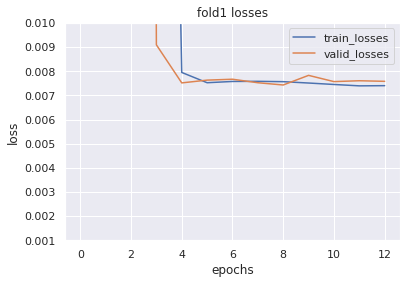

scored_loop
-----EPOCH1-----
train_loss: 0.63948, train_metric: 0.63940
valid_loss: 0.43571, valid_metric: 0.43538
-----EPOCH2-----
train_loss: 0.17241, train_metric: 0.17139
valid_loss: 0.04247, valid_metric: 0.04072
-----EPOCH3-----
train_loss: 0.02891, train_metric: 0.02672
valid_loss: 0.02283, valid_metric: 0.02028
-----EPOCH4-----
train_loss: 0.02186, train_metric: 0.01914
valid_loss: 0.02082, valid_metric: 0.01789
-----EPOCH5-----
train_loss: 0.02100, train_metric: 0.01805
valid_loss: 0.02154, valid_metric: 0.01830
-----EPOCH6-----
train_loss: 0.02086, train_metric: 0.01782
valid_loss: 0.02083, valid_metric: 0.01782
-----EPOCH7-----
train_loss: 0.02078, train_metric: 0.01772
valid_loss: 0.02078, valid_metric: 0.01768
-----EPOCH8-----
train_loss: 0.02082, train_metric: 0.01776
valid_loss: 0.02083, valid_metric: 0.01789
-----EPOCH9-----
train_loss: 0.02074, train_metric: 0.01769
valid_loss: 0.02046, valid_metric: 0.01737
-----EPOCH10-----
train_loss: 0.02078, train_metric: 0.01774


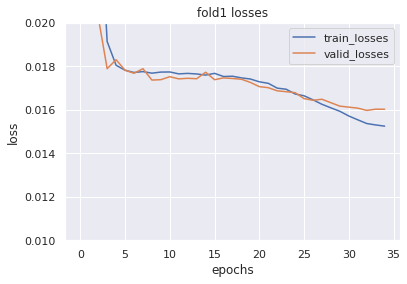

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72768, train_metric: 0.72768
valid_loss: 0.70416, valid_metric: 0.70416
-----EPOCH2-----
train_loss: 0.69354, train_metric: 0.69353
valid_loss: 0.67033, valid_metric: 0.67030
-----EPOCH3-----
train_loss: 0.52397, train_metric: 0.52377
valid_loss: 0.23686, valid_metric: 0.23619
-----EPOCH4-----
train_loss: 0.06313, train_metric: 0.06135
valid_loss: 0.01210, valid_metric: 0.00930
-----EPOCH5-----
train_loss: 0.01093, train_metric: 0.00780
valid_loss: 0.01110, valid_metric: 0.00786
-----EPOCH6-----
train_loss: 0.01068, train_metric: 0.00742
valid_loss: 0.01108, valid_metric: 0.00785
-----EPOCH7-----
train_loss: 0.01066, train_metric: 0.00745
valid_loss: 0.01111, valid_metric: 0.00796
-----EPOCH8-----
train_loss: 0.01064, train_metric: 0.00747
valid_loss: 0.01114, valid_metric: 0.00802
-----EPOCH9-----
train_loss: 0.01058, train_metric: 0.00741
valid_loss: 0.01102, valid_metric: 0.00778
-----EPOCH10-----
train_loss: 0.

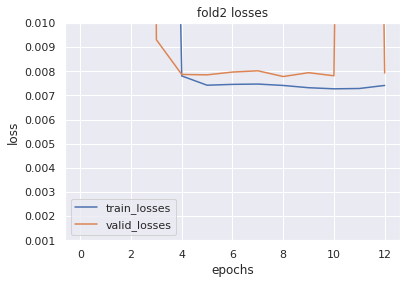

scored_loop
-----EPOCH1-----
train_loss: 0.63252, train_metric: 0.63242
valid_loss: 0.42322, valid_metric: 0.42288
-----EPOCH2-----
train_loss: 0.16921, train_metric: 0.16819
valid_loss: 0.04214, valid_metric: 0.04039
-----EPOCH3-----
train_loss: 0.02872, train_metric: 0.02652
valid_loss: 0.02279, valid_metric: 0.02027
-----EPOCH4-----
train_loss: 0.02186, train_metric: 0.01914
valid_loss: 0.02091, valid_metric: 0.01800
-----EPOCH5-----
train_loss: 0.02101, train_metric: 0.01806
valid_loss: 0.02119, valid_metric: 0.01834
-----EPOCH6-----
train_loss: 0.02073, train_metric: 0.01769
valid_loss: 0.02078, valid_metric: 0.01784
-----EPOCH7-----
train_loss: 0.02077, train_metric: 0.01771
valid_loss: 0.02071, valid_metric: 0.01769
-----EPOCH8-----
train_loss: 0.02074, train_metric: 0.01769
valid_loss: 0.02051, valid_metric: 0.01743
-----EPOCH9-----
train_loss: 0.02075, train_metric: 0.01770
valid_loss: 0.02078, valid_metric: 0.01768
-----EPOCH10-----
train_loss: 0.02084, train_metric: 0.01779


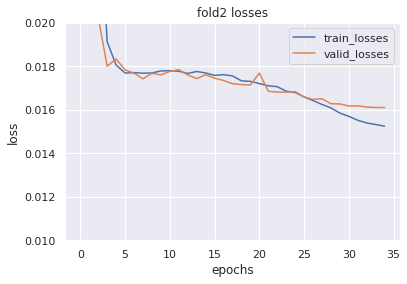

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72774, train_metric: 0.72774
valid_loss: 0.70366, valid_metric: 0.70366
-----EPOCH2-----
train_loss: 0.69357, train_metric: 0.69356
valid_loss: 0.66796, valid_metric: 0.66793
-----EPOCH3-----
train_loss: 0.52373, train_metric: 0.52352
valid_loss: 0.24113, valid_metric: 0.24047
-----EPOCH4-----
train_loss: 0.06311, train_metric: 0.06133
valid_loss: 0.01206, valid_metric: 0.00927
-----EPOCH5-----
train_loss: 0.01102, train_metric: 0.00789
valid_loss: 0.01093, valid_metric: 0.00766
-----EPOCH6-----
train_loss: 0.01075, train_metric: 0.00749
valid_loss: 0.01084, valid_metric: 0.00756
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00752
valid_loss: 0.01088, valid_metric: 0.00773
-----EPOCH8-----
train_loss: 0.01064, train_metric: 0.00747
valid_loss: 0.01088, valid_metric: 0.00759
-----EPOCH9-----
train_loss: 0.01060, train_metric: 0.00744
valid_loss: 0.01101, valid_metric: 0.00795
-----EPOCH10-----
train_loss: 0.

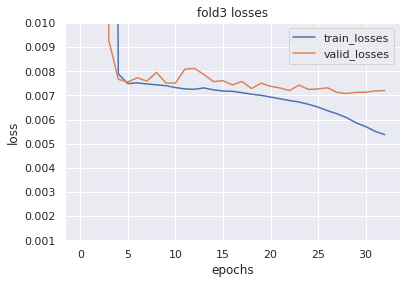

scored_loop
-----EPOCH1-----
train_loss: 0.59679, train_metric: 0.59667
valid_loss: 0.35430, valid_metric: 0.35386
-----EPOCH2-----
train_loss: 0.13746, train_metric: 0.13633
valid_loss: 0.03977, valid_metric: 0.03798
-----EPOCH3-----
train_loss: 0.02804, train_metric: 0.02583
valid_loss: 0.02293, valid_metric: 0.02041
-----EPOCH4-----
train_loss: 0.02185, train_metric: 0.01916
valid_loss: 0.02113, valid_metric: 0.01833
-----EPOCH5-----
train_loss: 0.02101, train_metric: 0.01810
valid_loss: 0.02072, valid_metric: 0.01768
-----EPOCH6-----
train_loss: 0.02093, train_metric: 0.01794
valid_loss: 0.02083, valid_metric: 0.01782
-----EPOCH7-----
train_loss: 0.02083, train_metric: 0.01781
valid_loss: 0.02081, valid_metric: 0.01785
-----EPOCH8-----
train_loss: 0.02085, train_metric: 0.01781
valid_loss: 0.02117, valid_metric: 0.01821
-----EPOCH9-----
train_loss: 0.02095, train_metric: 0.01791
valid_loss: 0.02061, valid_metric: 0.01754
-----EPOCH10-----
train_loss: 0.02092, train_metric: 0.01787


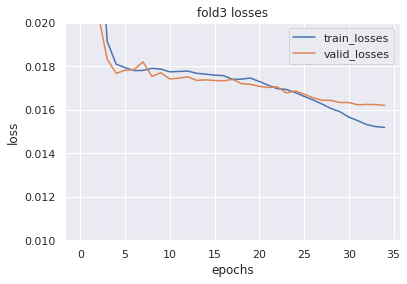

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72767, train_metric: 0.72767
valid_loss: 0.70520, valid_metric: 0.70520
-----EPOCH2-----
train_loss: 0.69370, train_metric: 0.69369
valid_loss: 0.66895, valid_metric: 0.66892
-----EPOCH3-----
train_loss: 0.52363, train_metric: 0.52342
valid_loss: 0.23617, valid_metric: 0.23550
-----EPOCH4-----
train_loss: 0.06306, train_metric: 0.06128
valid_loss: 0.01187, valid_metric: 0.00908
-----EPOCH5-----
train_loss: 0.01101, train_metric: 0.00788
valid_loss: 0.01075, valid_metric: 0.00749
-----EPOCH6-----
train_loss: 0.01076, train_metric: 0.00750
valid_loss: 0.01074, valid_metric: 0.00755
-----EPOCH7-----
train_loss: 0.01074, train_metric: 0.00754
valid_loss: 0.01083, valid_metric: 0.00773
-----EPOCH8-----
train_loss: 0.01069, train_metric: 0.00753
valid_loss: 0.01072, valid_metric: 0.00754
-----EPOCH9-----
train_loss: 0.01067, train_metric: 0.00750
valid_loss: 0.01070, valid_metric: 0.00754
-----EPOCH10-----
train_loss: 0.

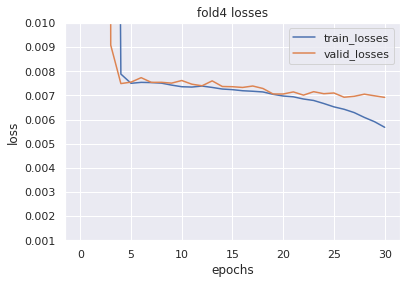

scored_loop
-----EPOCH1-----
train_loss: 0.59909, train_metric: 0.59897
valid_loss: 0.36070, valid_metric: 0.36026
-----EPOCH2-----
train_loss: 0.13889, train_metric: 0.13776
valid_loss: 0.04012, valid_metric: 0.03833
-----EPOCH3-----
train_loss: 0.02815, train_metric: 0.02595
valid_loss: 0.02268, valid_metric: 0.02014
-----EPOCH4-----
train_loss: 0.02197, train_metric: 0.01927
valid_loss: 0.02119, valid_metric: 0.01822
-----EPOCH5-----
train_loss: 0.02108, train_metric: 0.01818
valid_loss: 0.02087, valid_metric: 0.01776
-----EPOCH6-----
train_loss: 0.02086, train_metric: 0.01787
valid_loss: 0.02069, valid_metric: 0.01754
-----EPOCH7-----
train_loss: 0.02080, train_metric: 0.01777
valid_loss: 0.02082, valid_metric: 0.01765
-----EPOCH8-----
train_loss: 0.02082, train_metric: 0.01778
valid_loss: 0.02075, valid_metric: 0.01760
-----EPOCH9-----
train_loss: 0.02087, train_metric: 0.01783
valid_loss: 0.02084, valid_metric: 0.01775
-----EPOCH10-----
train_loss: 0.02085, train_metric: 0.01780


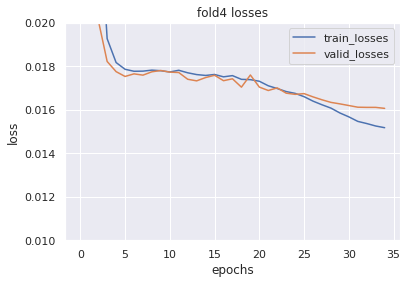

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72773, train_metric: 0.72773
valid_loss: 0.70342, valid_metric: 0.70341
-----EPOCH2-----
train_loss: 0.69366, train_metric: 0.69365
valid_loss: 0.67118, valid_metric: 0.67115
-----EPOCH3-----
train_loss: 0.52388, train_metric: 0.52367
valid_loss: 0.23226, valid_metric: 0.23158
-----EPOCH4-----
train_loss: 0.06331, train_metric: 0.06154
valid_loss: 0.01203, valid_metric: 0.00927
-----EPOCH5-----
train_loss: 0.01107, train_metric: 0.00794
valid_loss: 0.01071, valid_metric: 0.00748
-----EPOCH6-----
train_loss: 0.01081, train_metric: 0.00755
valid_loss: 0.01075, valid_metric: 0.00761
-----EPOCH7-----
train_loss: 0.01075, train_metric: 0.00755
valid_loss: 0.01072, valid_metric: 0.00760
-----EPOCH8-----
train_loss: 0.01073, train_metric: 0.00756
valid_loss: 0.01074, valid_metric: 0.00761
-----EPOCH9-----
train_loss: 0.01068, train_metric: 0.00751
valid_loss: 0.01065, valid_metric: 0.00750
-----EPOCH10-----
train_loss: 0.

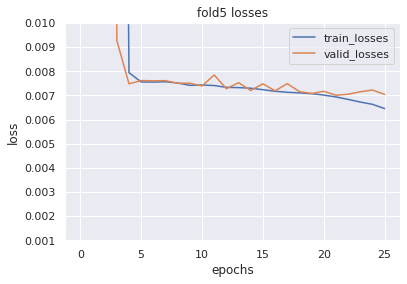

scored_loop
-----EPOCH1-----
train_loss: 0.59532, train_metric: 0.59519
valid_loss: 0.34730, valid_metric: 0.34685
-----EPOCH2-----
train_loss: 0.14064, train_metric: 0.13952
valid_loss: 0.04037, valid_metric: 0.03859
-----EPOCH3-----
train_loss: 0.02790, train_metric: 0.02569
valid_loss: 0.02304, valid_metric: 0.02054
-----EPOCH4-----
train_loss: 0.02176, train_metric: 0.01906
valid_loss: 0.02103, valid_metric: 0.01808
-----EPOCH5-----
train_loss: 0.02095, train_metric: 0.01803
valid_loss: 0.02082, valid_metric: 0.01785
-----EPOCH6-----
train_loss: 0.02087, train_metric: 0.01787
valid_loss: 0.02069, valid_metric: 0.01760
-----EPOCH7-----
train_loss: 0.02082, train_metric: 0.01780
valid_loss: 0.02098, valid_metric: 0.01795
-----EPOCH8-----
train_loss: 0.02081, train_metric: 0.01777
valid_loss: 0.02073, valid_metric: 0.01763
-----EPOCH9-----
train_loss: 0.02082, train_metric: 0.01777
valid_loss: 0.02073, valid_metric: 0.01770
-----EPOCH10-----
train_loss: 0.02094, train_metric: 0.01789


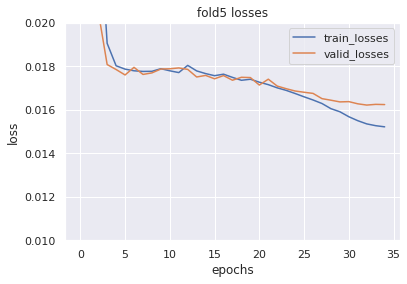

 
SEED : 1

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72474, train_metric: 0.72474
valid_loss: 0.70755, valid_metric: 0.70755
-----EPOCH2-----
train_loss: 0.69103, train_metric: 0.69102
valid_loss: 0.66021, valid_metric: 0.66017
-----EPOCH3-----
train_loss: 0.52193, train_metric: 0.52172
valid_loss: 0.22537, valid_metric: 0.22467
-----EPOCH4-----
train_loss: 0.06339, train_metric: 0.06161
valid_loss: 0.01196, valid_metric: 0.00916
-----EPOCH5-----
train_loss: 0.01111, train_metric: 0.00798
valid_loss: 0.01083, valid_metric: 0.00763
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00753
valid_loss: 0.01077, valid_metric: 0.00757
-----EPOCH7-----
train_loss: 0.01078, train_metric: 0.00759
valid_loss: 0.01089, valid_metric: 0.00784
-----EPOCH8-----
train_loss: 0.01075, train_metric: 0.00759
valid_loss: 0.01100, valid_metric: 0.00800
-----EPOCH9-----
train_loss: 0.01070, train_metric: 0.00754
valid_loss: 0.01099, valid_metric: 0.00796
-----EPOCH10-----
tr

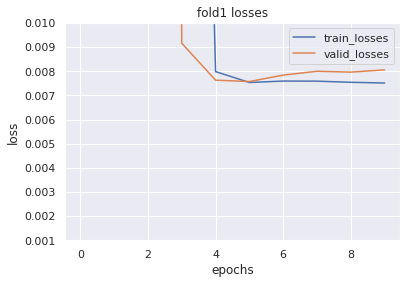

scored_loop
-----EPOCH1-----
train_loss: 0.64511, train_metric: 0.64502
valid_loss: 0.44506, valid_metric: 0.44475
-----EPOCH2-----
train_loss: 0.17679, train_metric: 0.17578
valid_loss: 0.04182, valid_metric: 0.04004
-----EPOCH3-----
train_loss: 0.02843, train_metric: 0.02620
valid_loss: 0.02268, valid_metric: 0.02009
-----EPOCH4-----
train_loss: 0.02194, train_metric: 0.01920
valid_loss: 0.02135, valid_metric: 0.01852
-----EPOCH5-----
train_loss: 0.02112, train_metric: 0.01816
valid_loss: 0.02085, valid_metric: 0.01789
-----EPOCH6-----
train_loss: 0.02103, train_metric: 0.01799
valid_loss: 0.02087, valid_metric: 0.01785
-----EPOCH7-----
train_loss: 0.02101, train_metric: 0.01795
valid_loss: 0.02051, valid_metric: 0.01740
-----EPOCH8-----
train_loss: 0.02096, train_metric: 0.01792
valid_loss: 0.02111, valid_metric: 0.01791
-----EPOCH9-----
train_loss: 0.02101, train_metric: 0.01797
valid_loss: 0.02081, valid_metric: 0.01769
-----EPOCH10-----
train_loss: 0.02087, train_metric: 0.01783


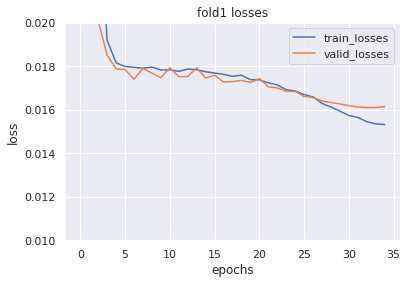

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72475, train_metric: 0.72475
valid_loss: 0.70724, valid_metric: 0.70724
-----EPOCH2-----
train_loss: 0.69093, train_metric: 0.69092
valid_loss: 0.66072, valid_metric: 0.66068
-----EPOCH3-----
train_loss: 0.52145, train_metric: 0.52124
valid_loss: 0.22602, valid_metric: 0.22532
-----EPOCH4-----
train_loss: 0.06310, train_metric: 0.06132
valid_loss: 0.01223, valid_metric: 0.00942
-----EPOCH5-----
train_loss: 0.01103, train_metric: 0.00790
valid_loss: 0.01114, valid_metric: 0.00792
-----EPOCH6-----
train_loss: 0.01075, train_metric: 0.00749
valid_loss: 0.01116, valid_metric: 0.00802
-----EPOCH7-----
train_loss: 0.01066, train_metric: 0.00747
valid_loss: 0.01116, valid_metric: 0.00806
-----EPOCH8-----
train_loss: 0.01066, train_metric: 0.00750
valid_loss: 0.01113, valid_metric: 0.00799
-----EPOCH9-----
train_loss: 0.01062, train_metric: 0.00746
valid_loss: 0.01111, valid_metric: 0.00797
-----EPOCH10-----
train_loss: 0.

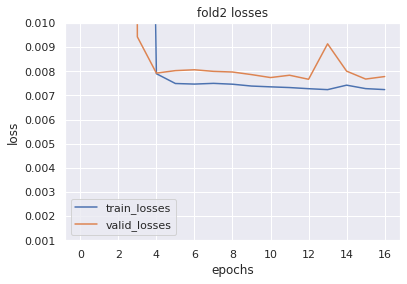

scored_loop
-----EPOCH1-----
train_loss: 0.62257, train_metric: 0.62247
valid_loss: 0.39833, valid_metric: 0.39796
-----EPOCH2-----
train_loss: 0.16142, train_metric: 0.16037
valid_loss: 0.04275, valid_metric: 0.04101
-----EPOCH3-----
train_loss: 0.02896, train_metric: 0.02677
valid_loss: 0.02257, valid_metric: 0.02001
-----EPOCH4-----
train_loss: 0.02195, train_metric: 0.01924
valid_loss: 0.02098, valid_metric: 0.01806
-----EPOCH5-----
train_loss: 0.02100, train_metric: 0.01807
valid_loss: 0.02051, valid_metric: 0.01750
-----EPOCH6-----
train_loss: 0.02083, train_metric: 0.01781
valid_loss: 0.02069, valid_metric: 0.01755
-----EPOCH7-----
train_loss: 0.02081, train_metric: 0.01777
valid_loss: 0.02063, valid_metric: 0.01765
-----EPOCH8-----
train_loss: 0.02072, train_metric: 0.01766
valid_loss: 0.02063, valid_metric: 0.01754
-----EPOCH9-----
train_loss: 0.02072, train_metric: 0.01767
valid_loss: 0.02109, valid_metric: 0.01811
-----EPOCH10-----
train_loss: 0.02067, train_metric: 0.01762


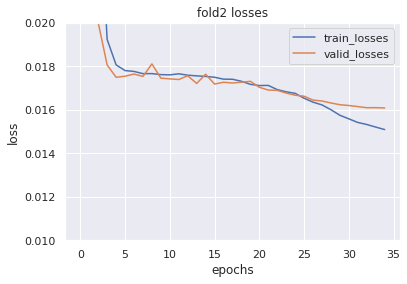

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72473, train_metric: 0.72472
valid_loss: 0.70702, valid_metric: 0.70702
-----EPOCH2-----
train_loss: 0.69098, train_metric: 0.69096
valid_loss: 0.66369, valid_metric: 0.66365
-----EPOCH3-----
train_loss: 0.52172, train_metric: 0.52151
valid_loss: 0.22135, valid_metric: 0.22064
-----EPOCH4-----
train_loss: 0.06317, train_metric: 0.06139
valid_loss: 0.01204, valid_metric: 0.00922
-----EPOCH5-----
train_loss: 0.01106, train_metric: 0.00792
valid_loss: 0.01098, valid_metric: 0.00773
-----EPOCH6-----
train_loss: 0.01076, train_metric: 0.00751
valid_loss: 0.01100, valid_metric: 0.00789
-----EPOCH7-----
train_loss: 0.01075, train_metric: 0.00756
valid_loss: 0.01090, valid_metric: 0.00773
-----EPOCH8-----
train_loss: 0.01069, train_metric: 0.00753
valid_loss: 0.01090, valid_metric: 0.00774
-----EPOCH9-----
train_loss: 0.01074, train_metric: 0.00758
valid_loss: 0.01163, valid_metric: 0.00802
-----EPOCH10-----
train_loss: 0.

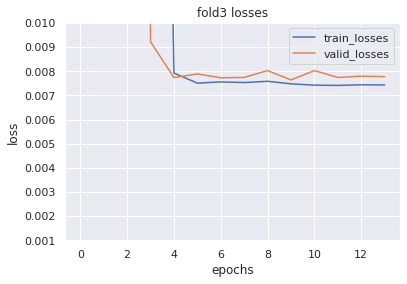

scored_loop
-----EPOCH1-----
train_loss: 0.63016, train_metric: 0.63006
valid_loss: 0.42239, valid_metric: 0.42205
-----EPOCH2-----
train_loss: 0.16960, train_metric: 0.16857
valid_loss: 0.04288, valid_metric: 0.04113
-----EPOCH3-----
train_loss: 0.02895, train_metric: 0.02675
valid_loss: 0.02324, valid_metric: 0.02071
-----EPOCH4-----
train_loss: 0.02195, train_metric: 0.01922
valid_loss: 0.02115, valid_metric: 0.01823
-----EPOCH5-----
train_loss: 0.02106, train_metric: 0.01812
valid_loss: 0.02083, valid_metric: 0.01786
-----EPOCH6-----
train_loss: 0.02096, train_metric: 0.01794
valid_loss: 0.02090, valid_metric: 0.01781
-----EPOCH7-----
train_loss: 0.02082, train_metric: 0.01777
valid_loss: 0.02051, valid_metric: 0.01749
-----EPOCH8-----
train_loss: 0.02088, train_metric: 0.01783
valid_loss: 0.02069, valid_metric: 0.01765
-----EPOCH9-----
train_loss: 0.02079, train_metric: 0.01774
valid_loss: 0.02054, valid_metric: 0.01742
-----EPOCH10-----
train_loss: 0.02085, train_metric: 0.01779


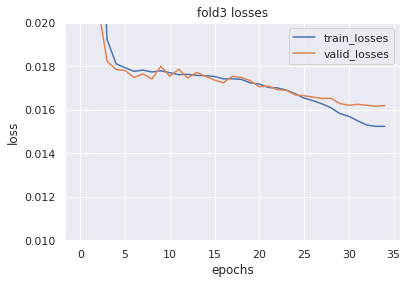

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72474, train_metric: 0.72474
valid_loss: 0.70732, valid_metric: 0.70732
-----EPOCH2-----
train_loss: 0.69105, train_metric: 0.69104
valid_loss: 0.66024, valid_metric: 0.66020
-----EPOCH3-----
train_loss: 0.52196, train_metric: 0.52175
valid_loss: 0.22505, valid_metric: 0.22435
-----EPOCH4-----
train_loss: 0.06338, train_metric: 0.06160
valid_loss: 0.01198, valid_metric: 0.00919
-----EPOCH5-----
train_loss: 0.01108, train_metric: 0.00795
valid_loss: 0.01082, valid_metric: 0.00759
-----EPOCH6-----
train_loss: 0.01085, train_metric: 0.00759
valid_loss: 0.01075, valid_metric: 0.00750
-----EPOCH7-----
train_loss: 0.01073, train_metric: 0.00754
valid_loss: 0.01075, valid_metric: 0.00760
-----EPOCH8-----
train_loss: 0.01072, train_metric: 0.00756
valid_loss: 0.01078, valid_metric: 0.00768
-----EPOCH9-----
train_loss: 0.01066, train_metric: 0.00750
valid_loss: 0.01101, valid_metric: 0.00802
-----EPOCH10-----
train_loss: 0.

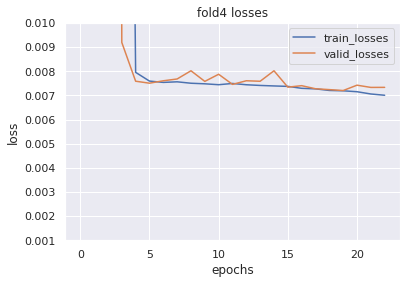

scored_loop
-----EPOCH1-----
train_loss: 0.59896, train_metric: 0.59884
valid_loss: 0.36641, valid_metric: 0.36599
-----EPOCH2-----
train_loss: 0.14593, train_metric: 0.14483
valid_loss: 0.04240, valid_metric: 0.04062
-----EPOCH3-----
train_loss: 0.02838, train_metric: 0.02618
valid_loss: 0.02529, valid_metric: 0.02283
-----EPOCH4-----
train_loss: 0.02198, train_metric: 0.01928
valid_loss: 0.02097, valid_metric: 0.01798
-----EPOCH5-----
train_loss: 0.02118, train_metric: 0.01827
valid_loss: 0.02097, valid_metric: 0.01792
-----EPOCH6-----
train_loss: 0.02096, train_metric: 0.01796
valid_loss: 0.02090, valid_metric: 0.01785
-----EPOCH7-----
train_loss: 0.02095, train_metric: 0.01792
valid_loss: 0.02062, valid_metric: 0.01754
-----EPOCH8-----
train_loss: 0.02087, train_metric: 0.01783
valid_loss: 0.02051, valid_metric: 0.01737
-----EPOCH9-----
train_loss: 0.02083, train_metric: 0.01778
valid_loss: 0.02074, valid_metric: 0.01758
-----EPOCH10-----
train_loss: 0.02086, train_metric: 0.01781


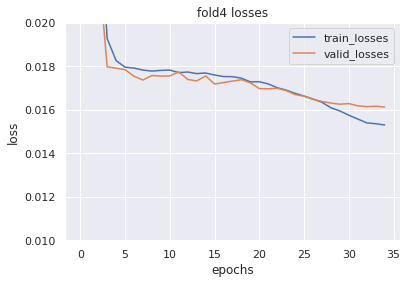

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72469, train_metric: 0.72469
valid_loss: 0.70760, valid_metric: 0.70760
-----EPOCH2-----
train_loss: 0.69110, train_metric: 0.69109
valid_loss: 0.65839, valid_metric: 0.65835
-----EPOCH3-----
train_loss: 0.52215, train_metric: 0.52194
valid_loss: 0.22556, valid_metric: 0.22486
-----EPOCH4-----
train_loss: 0.06319, train_metric: 0.06141
valid_loss: 0.01189, valid_metric: 0.00909
-----EPOCH5-----
train_loss: 0.01112, train_metric: 0.00799
valid_loss: 0.01076, valid_metric: 0.00750
-----EPOCH6-----
train_loss: 0.01080, train_metric: 0.00755
valid_loss: 0.01076, valid_metric: 0.00761
-----EPOCH7-----
train_loss: 0.01076, train_metric: 0.00757
valid_loss: 0.01073, valid_metric: 0.00761
-----EPOCH8-----
train_loss: 0.01074, train_metric: 0.00758
valid_loss: 0.01072, valid_metric: 0.00756
-----EPOCH9-----
train_loss: 0.01070, train_metric: 0.00755
valid_loss: 0.01072, valid_metric: 0.00759
-----EPOCH10-----
train_loss: 0.

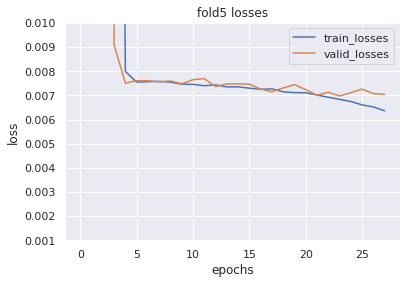

scored_loop
-----EPOCH1-----
train_loss: 0.60047, train_metric: 0.60035
valid_loss: 0.35683, valid_metric: 0.35639
-----EPOCH2-----
train_loss: 0.14089, train_metric: 0.13977
valid_loss: 0.03875, valid_metric: 0.03693
-----EPOCH3-----
train_loss: 0.02797, train_metric: 0.02577
valid_loss: 0.02283, valid_metric: 0.02030
-----EPOCH4-----
train_loss: 0.02185, train_metric: 0.01916
valid_loss: 0.02127, valid_metric: 0.01839
-----EPOCH5-----
train_loss: 0.02104, train_metric: 0.01813
valid_loss: 0.02119, valid_metric: 0.01833
-----EPOCH6-----
train_loss: 0.02089, train_metric: 0.01789
valid_loss: 0.02104, valid_metric: 0.01804
-----EPOCH7-----
train_loss: 0.02089, train_metric: 0.01787
valid_loss: 0.02121, valid_metric: 0.01819
-----EPOCH8-----
train_loss: 0.02078, train_metric: 0.01774
valid_loss: 0.02080, valid_metric: 0.01777
-----EPOCH9-----
train_loss: 0.02076, train_metric: 0.01772
valid_loss: 0.02118, valid_metric: 0.01812
-----EPOCH10-----
train_loss: 0.02081, train_metric: 0.01776


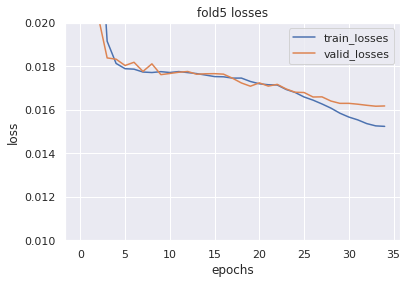

 
SEED : 2

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72625, train_metric: 0.72625
valid_loss: 0.70803, valid_metric: 0.70803
-----EPOCH2-----
train_loss: 0.69174, train_metric: 0.69173
valid_loss: 0.67859, valid_metric: 0.67857
-----EPOCH3-----
train_loss: 0.52132, train_metric: 0.52111
valid_loss: 0.23028, valid_metric: 0.22960
-----EPOCH4-----
train_loss: 0.06255, train_metric: 0.06077
valid_loss: 0.01185, valid_metric: 0.00905
-----EPOCH5-----
train_loss: 0.01105, train_metric: 0.00792
valid_loss: 0.01078, valid_metric: 0.00751
-----EPOCH6-----
train_loss: 0.01081, train_metric: 0.00756
valid_loss: 0.01074, valid_metric: 0.00754
-----EPOCH7-----
train_loss: 0.01079, train_metric: 0.00760
valid_loss: 0.01080, valid_metric: 0.00766
-----EPOCH8-----
train_loss: 0.01076, train_metric: 0.00760
valid_loss: 0.01072, valid_metric: 0.00756
-----EPOCH9-----
train_loss: 0.01072, train_metric: 0.00756
valid_loss: 0.01078, valid_metric: 0.00767
-----EPOCH10-----
tr

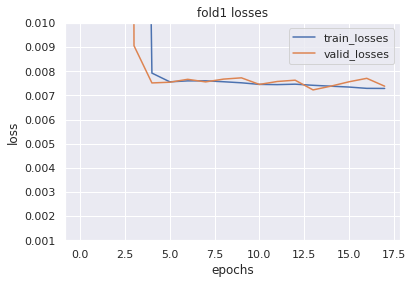

scored_loop
-----EPOCH1-----
train_loss: 0.61734, train_metric: 0.61723
valid_loss: 0.39809, valid_metric: 0.39772
-----EPOCH2-----
train_loss: 0.15796, train_metric: 0.15690
valid_loss: 0.04214, valid_metric: 0.04038
-----EPOCH3-----
train_loss: 0.02859, train_metric: 0.02640
valid_loss: 0.02308, valid_metric: 0.02059
-----EPOCH4-----
train_loss: 0.02178, train_metric: 0.01907
valid_loss: 0.02122, valid_metric: 0.01845
-----EPOCH5-----
train_loss: 0.02103, train_metric: 0.01810
valid_loss: 0.02088, valid_metric: 0.01774
-----EPOCH6-----
train_loss: 0.02082, train_metric: 0.01780
valid_loss: 0.02059, valid_metric: 0.01750
-----EPOCH7-----
train_loss: 0.02078, train_metric: 0.01774
valid_loss: 0.02049, valid_metric: 0.01731
-----EPOCH8-----
train_loss: 0.02083, train_metric: 0.01778
valid_loss: 0.02074, valid_metric: 0.01768
-----EPOCH9-----
train_loss: 0.02083, train_metric: 0.01778
valid_loss: 0.02063, valid_metric: 0.01757
-----EPOCH10-----
train_loss: 0.02077, train_metric: 0.01772


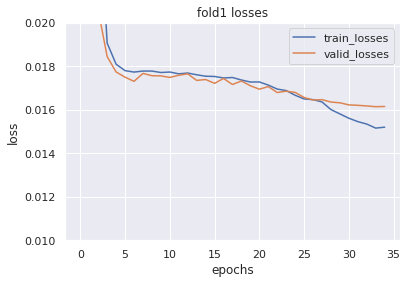

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72624, train_metric: 0.72624
valid_loss: 0.70622, valid_metric: 0.70622
-----EPOCH2-----
train_loss: 0.69173, train_metric: 0.69172
valid_loss: 0.67565, valid_metric: 0.67563
-----EPOCH3-----
train_loss: 0.52127, train_metric: 0.52106
valid_loss: 0.23009, valid_metric: 0.22941
-----EPOCH4-----
train_loss: 0.06243, train_metric: 0.06065
valid_loss: 0.01209, valid_metric: 0.00928
-----EPOCH5-----
train_loss: 0.01099, train_metric: 0.00786
valid_loss: 0.01110, valid_metric: 0.00780
-----EPOCH6-----
train_loss: 0.01069, train_metric: 0.00744
valid_loss: 0.01105, valid_metric: 0.00781
-----EPOCH7-----
train_loss: 0.01071, train_metric: 0.00752
valid_loss: 0.01106, valid_metric: 0.00790
-----EPOCH8-----
train_loss: 0.01071, train_metric: 0.00756
valid_loss: 0.01106, valid_metric: 0.00780
-----EPOCH9-----
train_loss: 0.01067, train_metric: 0.00751
valid_loss: 0.01104, valid_metric: 0.00786
-----EPOCH10-----
train_loss: 0.

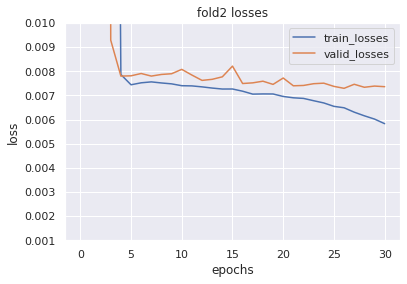

scored_loop
-----EPOCH1-----
train_loss: 0.59365, train_metric: 0.59352
valid_loss: 0.35304, valid_metric: 0.35260
-----EPOCH2-----
train_loss: 0.13786, train_metric: 0.13673
valid_loss: 0.03936, valid_metric: 0.03756
-----EPOCH3-----
train_loss: 0.02804, train_metric: 0.02583
valid_loss: 0.02266, valid_metric: 0.02013
-----EPOCH4-----
train_loss: 0.02194, train_metric: 0.01924
valid_loss: 0.02140, valid_metric: 0.01866
-----EPOCH5-----
train_loss: 0.02114, train_metric: 0.01823
valid_loss: 0.02106, valid_metric: 0.01817
-----EPOCH6-----
train_loss: 0.02100, train_metric: 0.01801
valid_loss: 0.02068, valid_metric: 0.01758
-----EPOCH7-----
train_loss: 0.02091, train_metric: 0.01789
valid_loss: 0.02064, valid_metric: 0.01770
-----EPOCH8-----
train_loss: 0.02085, train_metric: 0.01781
valid_loss: 0.02085, valid_metric: 0.01793
-----EPOCH9-----
train_loss: 0.02090, train_metric: 0.01786
valid_loss: 0.02059, valid_metric: 0.01755
-----EPOCH10-----
train_loss: 0.02087, train_metric: 0.01782


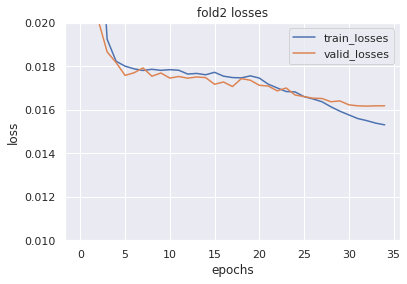

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72627, train_metric: 0.72627
valid_loss: 0.70756, valid_metric: 0.70756
-----EPOCH2-----
train_loss: 0.69172, train_metric: 0.69171
valid_loss: 0.67920, valid_metric: 0.67918
-----EPOCH3-----
train_loss: 0.52001, train_metric: 0.51980
valid_loss: 0.22847, valid_metric: 0.22779
-----EPOCH4-----
train_loss: 0.06164, train_metric: 0.05986
valid_loss: 0.01194, valid_metric: 0.00914
-----EPOCH5-----
train_loss: 0.01102, train_metric: 0.00789
valid_loss: 0.01094, valid_metric: 0.00769
-----EPOCH6-----
train_loss: 0.01075, train_metric: 0.00749
valid_loss: 0.01091, valid_metric: 0.00774
-----EPOCH7-----
train_loss: 0.01075, train_metric: 0.00755
valid_loss: 0.01082, valid_metric: 0.00757
-----EPOCH8-----
train_loss: 0.01070, train_metric: 0.00754
valid_loss: 0.01089, valid_metric: 0.00775
-----EPOCH9-----
train_loss: 0.01070, train_metric: 0.00754
valid_loss: 0.01087, valid_metric: 0.00770
-----EPOCH10-----
train_loss: 0.

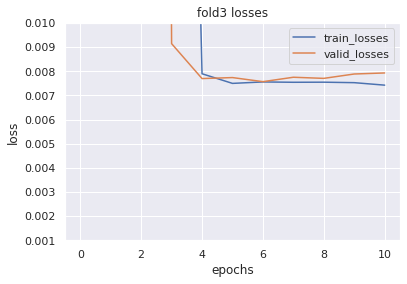

scored_loop
-----EPOCH1-----
train_loss: 0.64066, train_metric: 0.64057
valid_loss: 0.44314, valid_metric: 0.44284
-----EPOCH2-----
train_loss: 0.17539, train_metric: 0.17438
valid_loss: 0.04317, valid_metric: 0.04142
-----EPOCH3-----
train_loss: 0.02888, train_metric: 0.02667
valid_loss: 0.02301, valid_metric: 0.02047
-----EPOCH4-----
train_loss: 0.02195, train_metric: 0.01923
valid_loss: 0.02125, valid_metric: 0.01836
-----EPOCH5-----
train_loss: 0.02118, train_metric: 0.01823
valid_loss: 0.02100, valid_metric: 0.01798
-----EPOCH6-----
train_loss: 0.02107, train_metric: 0.01803
valid_loss: 0.02108, valid_metric: 0.01793
-----EPOCH7-----
train_loss: 0.02091, train_metric: 0.01786
valid_loss: 0.02086, valid_metric: 0.01787
-----EPOCH8-----
train_loss: 0.02094, train_metric: 0.01789
valid_loss: 0.02096, valid_metric: 0.01781
-----EPOCH9-----
train_loss: 0.02102, train_metric: 0.01797
valid_loss: 0.02098, valid_metric: 0.01777
-----EPOCH10-----
train_loss: 0.02090, train_metric: 0.01785


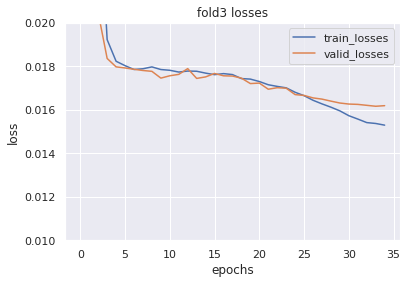

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72625, train_metric: 0.72625
valid_loss: 0.70701, valid_metric: 0.70701
-----EPOCH2-----
train_loss: 0.69170, train_metric: 0.69169
valid_loss: 0.67909, valid_metric: 0.67907
-----EPOCH3-----
train_loss: 0.52168, train_metric: 0.52148
valid_loss: 0.23181, valid_metric: 0.23113
-----EPOCH4-----
train_loss: 0.06279, train_metric: 0.06101
valid_loss: 0.01180, valid_metric: 0.00900
-----EPOCH5-----
train_loss: 0.01102, train_metric: 0.00790
valid_loss: 0.01075, valid_metric: 0.00747
-----EPOCH6-----
train_loss: 0.01078, train_metric: 0.00753
valid_loss: 0.01073, valid_metric: 0.00752
-----EPOCH7-----
train_loss: 0.01076, train_metric: 0.00757
valid_loss: 0.01079, valid_metric: 0.00766
-----EPOCH8-----
train_loss: 0.01078, train_metric: 0.00762
valid_loss: 0.01071, valid_metric: 0.00751
-----EPOCH9-----
train_loss: 0.01073, train_metric: 0.00757
valid_loss: 0.01088, valid_metric: 0.00773
-----EPOCH10-----
train_loss: 0.

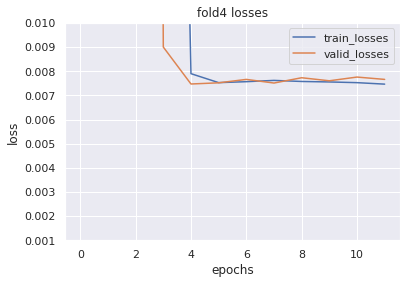

scored_loop
-----EPOCH1-----
train_loss: 0.64395, train_metric: 0.64386
valid_loss: 0.43895, valid_metric: 0.43864
-----EPOCH2-----
train_loss: 0.17445, train_metric: 0.17344
valid_loss: 0.04188, valid_metric: 0.04011
-----EPOCH3-----
train_loss: 0.02877, train_metric: 0.02657
valid_loss: 0.02287, valid_metric: 0.02032
-----EPOCH4-----
train_loss: 0.02186, train_metric: 0.01912
valid_loss: 0.02121, valid_metric: 0.01834
-----EPOCH5-----
train_loss: 0.02108, train_metric: 0.01812
valid_loss: 0.02105, valid_metric: 0.01800
-----EPOCH6-----
train_loss: 0.02090, train_metric: 0.01786
valid_loss: 0.02091, valid_metric: 0.01768
-----EPOCH7-----
train_loss: 0.02083, train_metric: 0.01777
valid_loss: 0.02088, valid_metric: 0.01774
-----EPOCH8-----
train_loss: 0.02086, train_metric: 0.01780
valid_loss: 0.02061, valid_metric: 0.01756
-----EPOCH9-----
train_loss: 0.02076, train_metric: 0.01771
valid_loss: 0.02106, valid_metric: 0.01785
-----EPOCH10-----
train_loss: 0.02090, train_metric: 0.01785


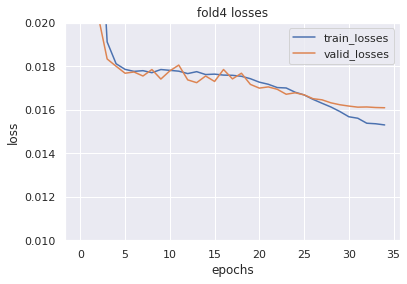

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72620, train_metric: 0.72620
valid_loss: 0.70679, valid_metric: 0.70679
-----EPOCH2-----
train_loss: 0.69167, train_metric: 0.69166
valid_loss: 0.67913, valid_metric: 0.67911
-----EPOCH3-----
train_loss: 0.52037, train_metric: 0.52016
valid_loss: 0.23146, valid_metric: 0.23078
-----EPOCH4-----
train_loss: 0.06199, train_metric: 0.06020
valid_loss: 0.01176, valid_metric: 0.00896
-----EPOCH5-----
train_loss: 0.01107, train_metric: 0.00794
valid_loss: 0.01070, valid_metric: 0.00742
-----EPOCH6-----
train_loss: 0.01083, train_metric: 0.00758
valid_loss: 0.01071, valid_metric: 0.00752
-----EPOCH7-----
train_loss: 0.01080, train_metric: 0.00761
valid_loss: 0.01069, valid_metric: 0.00753
-----EPOCH8-----
train_loss: 0.01082, train_metric: 0.00766
valid_loss: 0.01068, valid_metric: 0.00749
-----EPOCH9-----
train_loss: 0.01073, train_metric: 0.00758
valid_loss: 0.01063, valid_metric: 0.00742
-----EPOCH10-----
train_loss: 0.

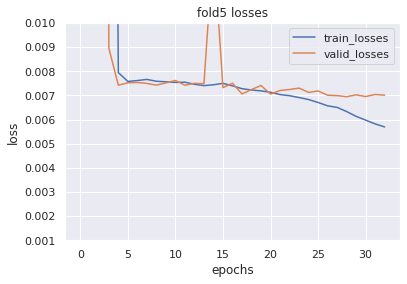

scored_loop
-----EPOCH1-----
train_loss: 0.59161, train_metric: 0.59148
valid_loss: 0.35322, valid_metric: 0.35277
-----EPOCH2-----
train_loss: 0.13676, train_metric: 0.13562
valid_loss: 0.04110, valid_metric: 0.03933
-----EPOCH3-----
train_loss: 0.02808, train_metric: 0.02587
valid_loss: 0.02292, valid_metric: 0.02038
-----EPOCH4-----
train_loss: 0.02199, train_metric: 0.01930
valid_loss: 0.02136, valid_metric: 0.01857
-----EPOCH5-----
train_loss: 0.02114, train_metric: 0.01824
valid_loss: 0.02092, valid_metric: 0.01780
-----EPOCH6-----
train_loss: 0.02093, train_metric: 0.01794
valid_loss: 0.02130, valid_metric: 0.01845
-----EPOCH7-----
train_loss: 0.02095, train_metric: 0.01792
valid_loss: 0.02084, valid_metric: 0.01764
-----EPOCH8-----
train_loss: 0.02080, train_metric: 0.01776
valid_loss: 0.02081, valid_metric: 0.01771
-----EPOCH9-----
train_loss: 0.02085, train_metric: 0.01781
valid_loss: 0.02114, valid_metric: 0.01799
-----EPOCH10-----
train_loss: 0.02079, train_metric: 0.01774


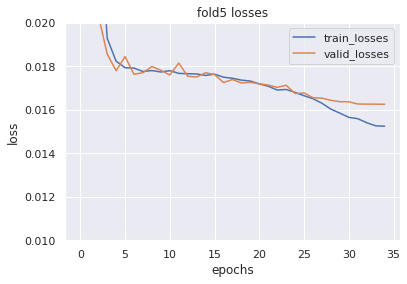

 
SEED : 3

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72638, train_metric: 0.72638
valid_loss: 0.70044, valid_metric: 0.70043
-----EPOCH2-----
train_loss: 0.69249, train_metric: 0.69248
valid_loss: 0.67259, valid_metric: 0.67256
-----EPOCH3-----
train_loss: 0.52154, train_metric: 0.52133
valid_loss: 0.23318, valid_metric: 0.23250
-----EPOCH4-----
train_loss: 0.06217, train_metric: 0.06038
valid_loss: 0.01195, valid_metric: 0.00917
-----EPOCH5-----
train_loss: 0.01102, train_metric: 0.00789
valid_loss: 0.01076, valid_metric: 0.00750
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00753
valid_loss: 0.01072, valid_metric: 0.00747
-----EPOCH7-----
train_loss: 0.01074, train_metric: 0.00755
valid_loss: 0.01070, valid_metric: 0.00752
-----EPOCH8-----
train_loss: 0.01071, train_metric: 0.00754
valid_loss: 0.01074, valid_metric: 0.00758
-----EPOCH9-----
train_loss: 0.01065, train_metric: 0.00749
valid_loss: 0.01067, valid_metric: 0.00748
-----EPOCH10-----
tr

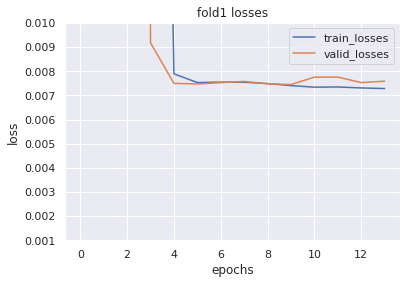

scored_loop
-----EPOCH1-----
train_loss: 0.62713, train_metric: 0.62703
valid_loss: 0.42997, valid_metric: 0.42961
-----EPOCH2-----
train_loss: 0.16756, train_metric: 0.16653
valid_loss: 0.04266, valid_metric: 0.04090
-----EPOCH3-----
train_loss: 0.02876, train_metric: 0.02656
valid_loss: 0.02238, valid_metric: 0.01977
-----EPOCH4-----
train_loss: 0.02185, train_metric: 0.01912
valid_loss: 0.02120, valid_metric: 0.01835
-----EPOCH5-----
train_loss: 0.02090, train_metric: 0.01795
valid_loss: 0.02066, valid_metric: 0.01765
-----EPOCH6-----
train_loss: 0.02080, train_metric: 0.01777
valid_loss: 0.02075, valid_metric: 0.01767
-----EPOCH7-----
train_loss: 0.02078, train_metric: 0.01772
valid_loss: 0.02046, valid_metric: 0.01746
-----EPOCH8-----
train_loss: 0.02078, train_metric: 0.01772
valid_loss: 0.02059, valid_metric: 0.01756
-----EPOCH9-----
train_loss: 0.02079, train_metric: 0.01773
valid_loss: 0.02047, valid_metric: 0.01734
-----EPOCH10-----
train_loss: 0.02074, train_metric: 0.01769


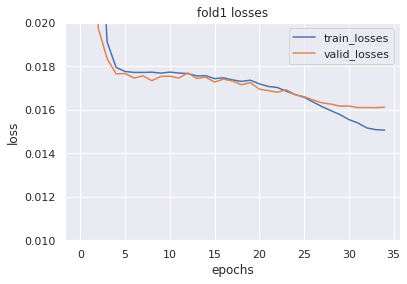

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72636, train_metric: 0.72636
valid_loss: 0.70023, valid_metric: 0.70023
-----EPOCH2-----
train_loss: 0.69233, train_metric: 0.69232
valid_loss: 0.67156, valid_metric: 0.67153
-----EPOCH3-----
train_loss: 0.52008, train_metric: 0.51987
valid_loss: 0.22928, valid_metric: 0.22859
-----EPOCH4-----
train_loss: 0.06126, train_metric: 0.05946
valid_loss: 0.01206, valid_metric: 0.00926
-----EPOCH5-----
train_loss: 0.01096, train_metric: 0.00782
valid_loss: 0.01108, valid_metric: 0.00783
-----EPOCH6-----
train_loss: 0.01066, train_metric: 0.00740
valid_loss: 0.01107, valid_metric: 0.00787
-----EPOCH7-----
train_loss: 0.01065, train_metric: 0.00745
valid_loss: 0.01106, valid_metric: 0.00788
-----EPOCH8-----
train_loss: 0.01064, train_metric: 0.00747
valid_loss: 0.01121, valid_metric: 0.00817
-----EPOCH9-----
train_loss: 0.01059, train_metric: 0.00743
valid_loss: 0.01099, valid_metric: 0.00779
-----EPOCH10-----
train_loss: 0.

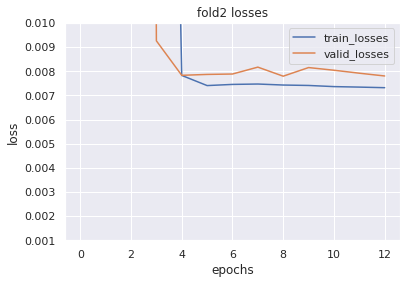

scored_loop
-----EPOCH1-----
train_loss: 0.64030, train_metric: 0.64022
valid_loss: 0.43328, valid_metric: 0.43295
-----EPOCH2-----
train_loss: 0.17419, train_metric: 0.17318
valid_loss: 0.04284, valid_metric: 0.04109
-----EPOCH3-----
train_loss: 0.02896, train_metric: 0.02677
valid_loss: 0.02307, valid_metric: 0.02055
-----EPOCH4-----
train_loss: 0.02177, train_metric: 0.01905
valid_loss: 0.02089, valid_metric: 0.01796
-----EPOCH5-----
train_loss: 0.02094, train_metric: 0.01799
valid_loss: 0.02119, valid_metric: 0.01795
-----EPOCH6-----
train_loss: 0.02084, train_metric: 0.01780
valid_loss: 0.02053, valid_metric: 0.01740
-----EPOCH7-----
train_loss: 0.02071, train_metric: 0.01765
valid_loss: 0.02060, valid_metric: 0.01749
-----EPOCH8-----
train_loss: 0.02081, train_metric: 0.01775
valid_loss: 0.02045, valid_metric: 0.01741
-----EPOCH9-----
train_loss: 0.02074, train_metric: 0.01769
valid_loss: 0.02057, valid_metric: 0.01740
-----EPOCH10-----
train_loss: 0.02078, train_metric: 0.01773


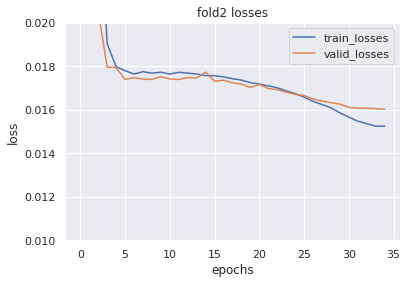

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72633, train_metric: 0.72633
valid_loss: 0.69964, valid_metric: 0.69964
-----EPOCH2-----
train_loss: 0.69230, train_metric: 0.69229
valid_loss: 0.67210, valid_metric: 0.67208
-----EPOCH3-----
train_loss: 0.51985, train_metric: 0.51964
valid_loss: 0.22427, valid_metric: 0.22357
-----EPOCH4-----
train_loss: 0.06112, train_metric: 0.05933
valid_loss: 0.01198, valid_metric: 0.00917
-----EPOCH5-----
train_loss: 0.01098, train_metric: 0.00784
valid_loss: 0.01092, valid_metric: 0.00767
-----EPOCH6-----
train_loss: 0.01073, train_metric: 0.00747
valid_loss: 0.01097, valid_metric: 0.00781
-----EPOCH7-----
train_loss: 0.01074, train_metric: 0.00755
valid_loss: 0.01088, valid_metric: 0.00770
-----EPOCH8-----
train_loss: 0.01069, train_metric: 0.00753
valid_loss: 0.01086, valid_metric: 0.00769
-----EPOCH9-----
train_loss: 0.01061, train_metric: 0.00745
valid_loss: 0.01094, valid_metric: 0.00784
-----EPOCH10-----
train_loss: 0.

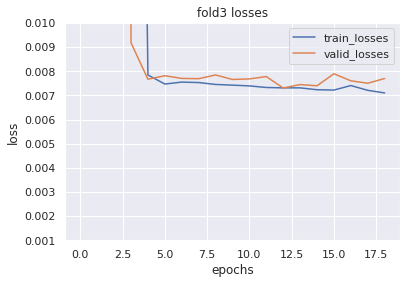

scored_loop
-----EPOCH1-----
train_loss: 0.61486, train_metric: 0.61475
valid_loss: 0.39028, valid_metric: 0.38990
-----EPOCH2-----
train_loss: 0.15683, train_metric: 0.15578
valid_loss: 0.04183, valid_metric: 0.04007
-----EPOCH3-----
train_loss: 0.02879, train_metric: 0.02660
valid_loss: 0.02279, valid_metric: 0.02026
-----EPOCH4-----
train_loss: 0.02185, train_metric: 0.01914
valid_loss: 0.02121, valid_metric: 0.01840
-----EPOCH5-----
train_loss: 0.02104, train_metric: 0.01811
valid_loss: 0.02079, valid_metric: 0.01773
-----EPOCH6-----
train_loss: 0.02093, train_metric: 0.01791
valid_loss: 0.02078, valid_metric: 0.01780
-----EPOCH7-----
train_loss: 0.02084, train_metric: 0.01780
valid_loss: 0.02093, valid_metric: 0.01787
-----EPOCH8-----
train_loss: 0.02077, train_metric: 0.01773
valid_loss: 0.02072, valid_metric: 0.01772
-----EPOCH9-----
train_loss: 0.02086, train_metric: 0.01781
valid_loss: 0.02060, valid_metric: 0.01755
-----EPOCH10-----
train_loss: 0.02080, train_metric: 0.01775


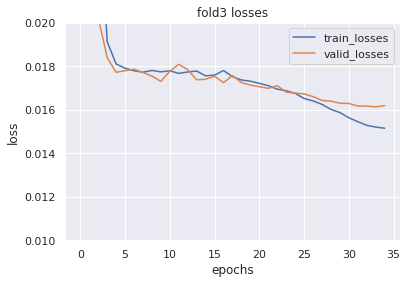

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72628, train_metric: 0.72628
valid_loss: 0.70098, valid_metric: 0.70098
-----EPOCH2-----
train_loss: 0.69241, train_metric: 0.69240
valid_loss: 0.67106, valid_metric: 0.67103
-----EPOCH3-----
train_loss: 0.52120, train_metric: 0.52099
valid_loss: 0.23178, valid_metric: 0.23109
-----EPOCH4-----
train_loss: 0.06206, train_metric: 0.06027
valid_loss: 0.01185, valid_metric: 0.00905
-----EPOCH5-----
train_loss: 0.01101, train_metric: 0.00787
valid_loss: 0.01080, valid_metric: 0.00758
-----EPOCH6-----
train_loss: 0.01074, train_metric: 0.00748
valid_loss: 0.01074, valid_metric: 0.00756
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00752
valid_loss: 0.01070, valid_metric: 0.00750
-----EPOCH8-----
train_loss: 0.01071, train_metric: 0.00754
valid_loss: 0.01068, valid_metric: 0.00750
-----EPOCH9-----
train_loss: 0.01069, train_metric: 0.00752
valid_loss: 0.01087, valid_metric: 0.00780
-----EPOCH10-----
train_loss: 0.

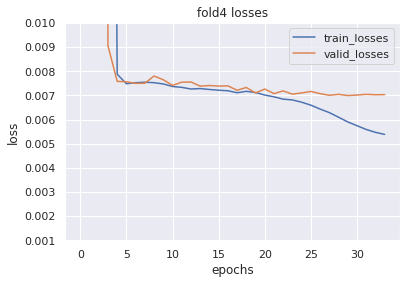

scored_loop
-----EPOCH1-----
train_loss: 0.59506, train_metric: 0.59494
valid_loss: 0.35127, valid_metric: 0.35082
-----EPOCH2-----
train_loss: 0.13677, train_metric: 0.13563
valid_loss: 0.03903, valid_metric: 0.03722
-----EPOCH3-----
train_loss: 0.02806, train_metric: 0.02585
valid_loss: 0.02268, valid_metric: 0.02012
-----EPOCH4-----
train_loss: 0.02204, train_metric: 0.01934
valid_loss: 0.02159, valid_metric: 0.01887
-----EPOCH5-----
train_loss: 0.02123, train_metric: 0.01833
valid_loss: 0.02087, valid_metric: 0.01784
-----EPOCH6-----
train_loss: 0.02101, train_metric: 0.01801
valid_loss: 0.02085, valid_metric: 0.01780
-----EPOCH7-----
train_loss: 0.02094, train_metric: 0.01792
valid_loss: 0.02080, valid_metric: 0.01779
-----EPOCH8-----
train_loss: 0.02093, train_metric: 0.01790
valid_loss: 0.02064, valid_metric: 0.01756
-----EPOCH9-----
train_loss: 0.02095, train_metric: 0.01791
valid_loss: 0.02074, valid_metric: 0.01762
-----EPOCH10-----
train_loss: 0.02086, train_metric: 0.01781


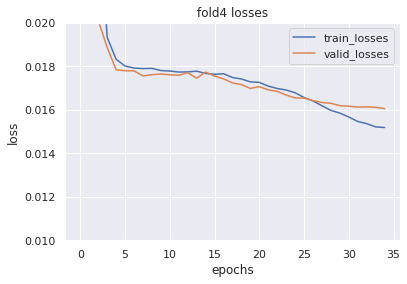

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72632, train_metric: 0.72632
valid_loss: 0.69927, valid_metric: 0.69926
-----EPOCH2-----
train_loss: 0.69235, train_metric: 0.69234
valid_loss: 0.67098, valid_metric: 0.67095
-----EPOCH3-----
train_loss: 0.52103, train_metric: 0.52082
valid_loss: 0.22643, valid_metric: 0.22573
-----EPOCH4-----
train_loss: 0.06189, train_metric: 0.06010
valid_loss: 0.01164, valid_metric: 0.00881
-----EPOCH5-----
train_loss: 0.01110, train_metric: 0.00797
valid_loss: 0.01072, valid_metric: 0.00749
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00754
valid_loss: 0.01071, valid_metric: 0.00754
-----EPOCH7-----
train_loss: 0.01076, train_metric: 0.00757
valid_loss: 0.01071, valid_metric: 0.00756
-----EPOCH8-----
train_loss: 0.01071, train_metric: 0.00755
valid_loss: 0.01065, valid_metric: 0.00748
-----EPOCH9-----
train_loss: 0.01068, train_metric: 0.00752
valid_loss: 0.01076, valid_metric: 0.00765
-----EPOCH10-----
train_loss: 0.

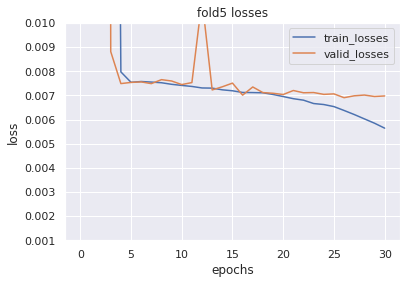

scored_loop
-----EPOCH1-----
train_loss: 0.59260, train_metric: 0.59248
valid_loss: 0.35077, valid_metric: 0.35032
-----EPOCH2-----
train_loss: 0.13752, train_metric: 0.13638
valid_loss: 0.03978, valid_metric: 0.03799
-----EPOCH3-----
train_loss: 0.02806, train_metric: 0.02585
valid_loss: 0.02284, valid_metric: 0.02030
-----EPOCH4-----
train_loss: 0.02192, train_metric: 0.01922
valid_loss: 0.02152, valid_metric: 0.01875
-----EPOCH5-----
train_loss: 0.02113, train_metric: 0.01822
valid_loss: 0.02132, valid_metric: 0.01842
-----EPOCH6-----
train_loss: 0.02103, train_metric: 0.01804
valid_loss: 0.02093, valid_metric: 0.01785
-----EPOCH7-----
train_loss: 0.02088, train_metric: 0.01786
valid_loss: 0.02075, valid_metric: 0.01767
-----EPOCH8-----
train_loss: 0.02100, train_metric: 0.01797
valid_loss: 0.02161, valid_metric: 0.01835
-----EPOCH9-----
train_loss: 0.02100, train_metric: 0.01797
valid_loss: 0.02111, valid_metric: 0.01797
-----EPOCH10-----
train_loss: 0.02087, train_metric: 0.01782


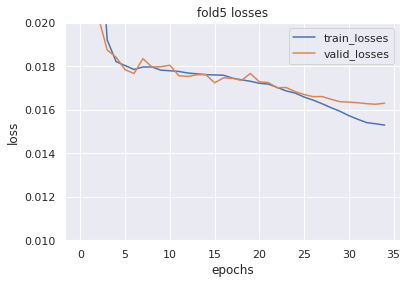

 
SEED : 4

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72715, train_metric: 0.72715
valid_loss: 0.70500, valid_metric: 0.70499
-----EPOCH2-----
train_loss: 0.69289, train_metric: 0.69288
valid_loss: 0.68061, valid_metric: 0.68059
-----EPOCH3-----
train_loss: 0.52070, train_metric: 0.52049
valid_loss: 0.22632, valid_metric: 0.22562
-----EPOCH4-----
train_loss: 0.06163, train_metric: 0.05984
valid_loss: 0.01182, valid_metric: 0.00902
-----EPOCH5-----
train_loss: 0.01100, train_metric: 0.00786
valid_loss: 0.01078, valid_metric: 0.00753
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00753
valid_loss: 0.01071, valid_metric: 0.00743
-----EPOCH7-----
train_loss: 0.01076, train_metric: 0.00757
valid_loss: 0.01091, valid_metric: 0.00782
-----EPOCH8-----
train_loss: 0.01073, train_metric: 0.00757
valid_loss: 0.01075, valid_metric: 0.00758
-----EPOCH9-----
train_loss: 0.01075, train_metric: 0.00759
valid_loss: 0.01069, valid_metric: 0.00748
-----EPOCH10-----
tr

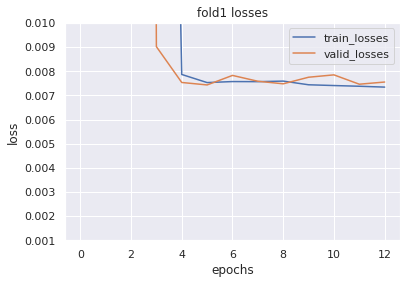

scored_loop
-----EPOCH1-----
train_loss: 0.63278, train_metric: 0.63269
valid_loss: 0.42658, valid_metric: 0.42625
-----EPOCH2-----
train_loss: 0.17051, train_metric: 0.16949
valid_loss: 0.04288, valid_metric: 0.04114
-----EPOCH3-----
train_loss: 0.02882, train_metric: 0.02662
valid_loss: 0.02338, valid_metric: 0.02088
-----EPOCH4-----
train_loss: 0.02193, train_metric: 0.01920
valid_loss: 0.02122, valid_metric: 0.01836
-----EPOCH5-----
train_loss: 0.02106, train_metric: 0.01811
valid_loss: 0.02082, valid_metric: 0.01780
-----EPOCH6-----
train_loss: 0.02096, train_metric: 0.01792
valid_loss: 0.02151, valid_metric: 0.01855
-----EPOCH7-----
train_loss: 0.02091, train_metric: 0.01786
valid_loss: 0.02051, valid_metric: 0.01746
-----EPOCH8-----
train_loss: 0.02084, train_metric: 0.01779
valid_loss: 0.02106, valid_metric: 0.01782
-----EPOCH9-----
train_loss: 0.02091, train_metric: 0.01786
valid_loss: 0.02090, valid_metric: 0.01784
-----EPOCH10-----
train_loss: 0.02096, train_metric: 0.01791


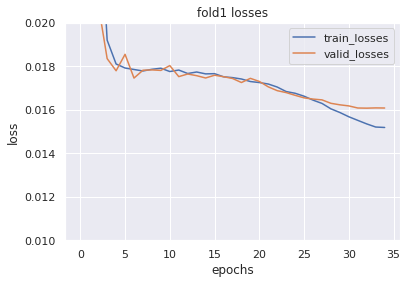

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72716, train_metric: 0.72716
valid_loss: 0.70384, valid_metric: 0.70384
-----EPOCH2-----
train_loss: 0.69280, train_metric: 0.69279
valid_loss: 0.68156, valid_metric: 0.68154
-----EPOCH3-----
train_loss: 0.52080, train_metric: 0.52059
valid_loss: 0.22911, valid_metric: 0.22843
-----EPOCH4-----
train_loss: 0.06180, train_metric: 0.06001
valid_loss: 0.01213, valid_metric: 0.00933
-----EPOCH5-----
train_loss: 0.01098, train_metric: 0.00784
valid_loss: 0.01110, valid_metric: 0.00785
-----EPOCH6-----
train_loss: 0.01068, train_metric: 0.00742
valid_loss: 0.01104, valid_metric: 0.00779
-----EPOCH7-----
train_loss: 0.01068, train_metric: 0.00748
valid_loss: 0.01111, valid_metric: 0.00796
-----EPOCH8-----
train_loss: 0.01063, train_metric: 0.00746
valid_loss: 0.01128, valid_metric: 0.00814
-----EPOCH9-----
train_loss: 0.01073, train_metric: 0.00756
valid_loss: 0.01106, valid_metric: 0.00787
-----EPOCH10-----
train_loss: 0.

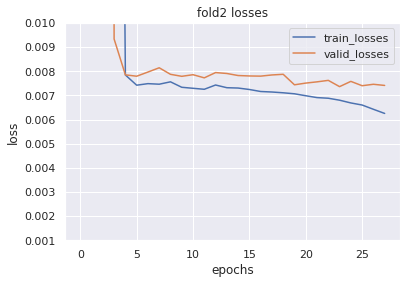

scored_loop
-----EPOCH1-----
train_loss: 0.59297, train_metric: 0.59285
valid_loss: 0.35577, valid_metric: 0.35533
-----EPOCH2-----
train_loss: 0.13902, train_metric: 0.13789
valid_loss: 0.03915, valid_metric: 0.03735
-----EPOCH3-----
train_loss: 0.02797, train_metric: 0.02576
valid_loss: 0.02261, valid_metric: 0.02008
-----EPOCH4-----
train_loss: 0.02186, train_metric: 0.01916
valid_loss: 0.02133, valid_metric: 0.01860
-----EPOCH5-----
train_loss: 0.02111, train_metric: 0.01819
valid_loss: 0.02054, valid_metric: 0.01751
-----EPOCH6-----
train_loss: 0.02086, train_metric: 0.01786
valid_loss: 0.02084, valid_metric: 0.01784
-----EPOCH7-----
train_loss: 0.02079, train_metric: 0.01776
valid_loss: 0.02061, valid_metric: 0.01759
-----EPOCH8-----
train_loss: 0.02088, train_metric: 0.01784
valid_loss: 0.02058, valid_metric: 0.01753
-----EPOCH9-----
train_loss: 0.02083, train_metric: 0.01779
valid_loss: 0.02047, valid_metric: 0.01733
-----EPOCH10-----
train_loss: 0.02076, train_metric: 0.01771


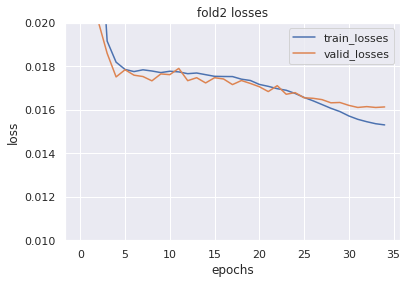

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72716, train_metric: 0.72716
valid_loss: 0.70386, valid_metric: 0.70386
-----EPOCH2-----
train_loss: 0.69284, train_metric: 0.69283
valid_loss: 0.68348, valid_metric: 0.68346
-----EPOCH3-----
train_loss: 0.52062, train_metric: 0.52041
valid_loss: 0.22502, valid_metric: 0.22432
-----EPOCH4-----
train_loss: 0.06159, train_metric: 0.05980
valid_loss: 0.01192, valid_metric: 0.00912
-----EPOCH5-----
train_loss: 0.01097, train_metric: 0.00784
valid_loss: 0.01093, valid_metric: 0.00764
-----EPOCH6-----
train_loss: 0.01069, train_metric: 0.00743
valid_loss: 0.01090, valid_metric: 0.00761
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00752
valid_loss: 0.01085, valid_metric: 0.00766
-----EPOCH8-----
train_loss: 0.01072, train_metric: 0.00755
valid_loss: 0.01090, valid_metric: 0.00772
-----EPOCH9-----
train_loss: 0.01062, train_metric: 0.00746
valid_loss: 0.01084, valid_metric: 0.00766
-----EPOCH10-----
train_loss: 0.

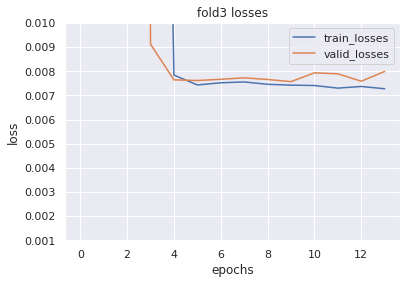

scored_loop
-----EPOCH1-----
train_loss: 0.62889, train_metric: 0.62880
valid_loss: 0.42539, valid_metric: 0.42505
-----EPOCH2-----
train_loss: 0.16766, train_metric: 0.16664
valid_loss: 0.04184, valid_metric: 0.04007
-----EPOCH3-----
train_loss: 0.02903, train_metric: 0.02683
valid_loss: 0.02273, valid_metric: 0.02016
-----EPOCH4-----
train_loss: 0.02207, train_metric: 0.01936
valid_loss: 0.02139, valid_metric: 0.01856
-----EPOCH5-----
train_loss: 0.02115, train_metric: 0.01821
valid_loss: 0.02069, valid_metric: 0.01766
-----EPOCH6-----
train_loss: 0.02090, train_metric: 0.01787
valid_loss: 0.02074, valid_metric: 0.01765
-----EPOCH7-----
train_loss: 0.02078, train_metric: 0.01772
valid_loss: 0.02065, valid_metric: 0.01759
-----EPOCH8-----
train_loss: 0.02084, train_metric: 0.01778
valid_loss: 0.02057, valid_metric: 0.01738
-----EPOCH9-----
train_loss: 0.02085, train_metric: 0.01781
valid_loss: 0.02066, valid_metric: 0.01770
-----EPOCH10-----
train_loss: 0.02080, train_metric: 0.01775


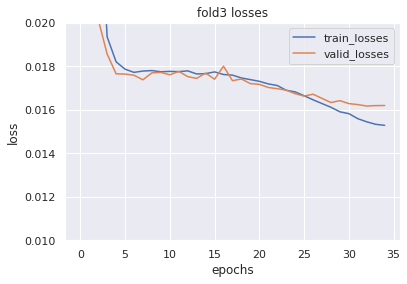

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72716, train_metric: 0.72716
valid_loss: 0.70430, valid_metric: 0.70430
-----EPOCH2-----
train_loss: 0.69273, train_metric: 0.69272
valid_loss: 0.68236, valid_metric: 0.68234
-----EPOCH3-----
train_loss: 0.52093, train_metric: 0.52072
valid_loss: 0.22732, valid_metric: 0.22663
-----EPOCH4-----
train_loss: 0.06178, train_metric: 0.05999
valid_loss: 0.01185, valid_metric: 0.00905
-----EPOCH5-----
train_loss: 0.01101, train_metric: 0.00788
valid_loss: 0.01075, valid_metric: 0.00749
-----EPOCH6-----
train_loss: 0.01075, train_metric: 0.00749
valid_loss: 0.01094, valid_metric: 0.00786
-----EPOCH7-----
train_loss: 0.01073, train_metric: 0.00753
valid_loss: 0.01079, valid_metric: 0.00768
-----EPOCH8-----
train_loss: 0.01072, train_metric: 0.00755
valid_loss: 0.01077, valid_metric: 0.00766
-----EPOCH9-----
train_loss: 0.01064, train_metric: 0.00747
valid_loss: 0.01079, valid_metric: 0.00762
early_stopping


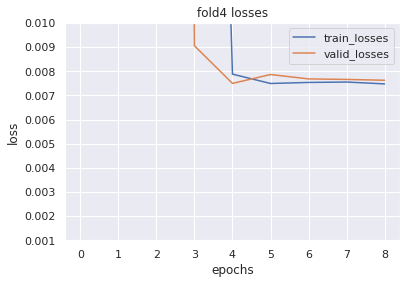

scored_loop
-----EPOCH1-----
train_loss: 0.64505, train_metric: 0.64497
valid_loss: 0.44269, valid_metric: 0.44238
-----EPOCH2-----
train_loss: 0.17971, train_metric: 0.17870
valid_loss: 0.04160, valid_metric: 0.03982
-----EPOCH3-----
train_loss: 0.02858, train_metric: 0.02636
valid_loss: 0.02316, valid_metric: 0.02064
-----EPOCH4-----
train_loss: 0.02205, train_metric: 0.01931
valid_loss: 0.02134, valid_metric: 0.01847
-----EPOCH5-----
train_loss: 0.02115, train_metric: 0.01819
valid_loss: 0.02095, valid_metric: 0.01788
-----EPOCH6-----
train_loss: 0.02094, train_metric: 0.01789
valid_loss: 0.02067, valid_metric: 0.01761
-----EPOCH7-----
train_loss: 0.02091, train_metric: 0.01785
valid_loss: 0.02075, valid_metric: 0.01769
-----EPOCH8-----
train_loss: 0.02092, train_metric: 0.01787
valid_loss: 0.02062, valid_metric: 0.01756
-----EPOCH9-----
train_loss: 0.02089, train_metric: 0.01784
valid_loss: 0.02109, valid_metric: 0.01790
-----EPOCH10-----
train_loss: 0.02096, train_metric: 0.01791


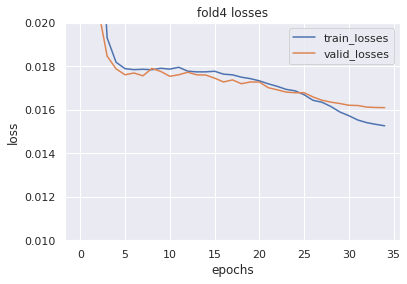

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72718, train_metric: 0.72718
valid_loss: 0.70444, valid_metric: 0.70443
-----EPOCH2-----
train_loss: 0.69278, train_metric: 0.69277
valid_loss: 0.68368, valid_metric: 0.68367
-----EPOCH3-----
train_loss: 0.52123, train_metric: 0.52102
valid_loss: 0.23146, valid_metric: 0.23078
-----EPOCH4-----
train_loss: 0.06192, train_metric: 0.06013
valid_loss: 0.01177, valid_metric: 0.00897
-----EPOCH5-----
train_loss: 0.01103, train_metric: 0.00790
valid_loss: 0.01068, valid_metric: 0.00740
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00753
valid_loss: 0.01075, valid_metric: 0.00762
-----EPOCH7-----
train_loss: 0.01077, train_metric: 0.00757
valid_loss: 0.01062, valid_metric: 0.00741
-----EPOCH8-----
train_loss: 0.01076, train_metric: 0.00760
valid_loss: 0.01068, valid_metric: 0.00746
-----EPOCH9-----
train_loss: 0.01074, train_metric: 0.00758
valid_loss: 0.01074, valid_metric: 0.00763
-----EPOCH10-----
train_loss: 0.

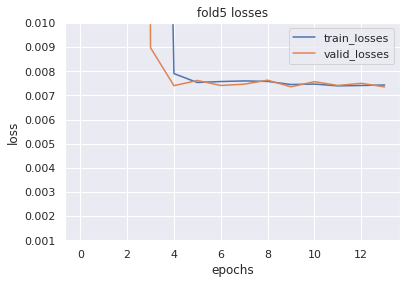

scored_loop
-----EPOCH1-----
train_loss: 0.62258, train_metric: 0.62247
valid_loss: 0.41601, valid_metric: 0.41565
-----EPOCH2-----
train_loss: 0.16714, train_metric: 0.16612
valid_loss: 0.04270, valid_metric: 0.04096
-----EPOCH3-----
train_loss: 0.02893, train_metric: 0.02674
valid_loss: 0.02317, valid_metric: 0.02066
-----EPOCH4-----
train_loss: 0.02192, train_metric: 0.01920
valid_loss: 0.02111, valid_metric: 0.01824
-----EPOCH5-----
train_loss: 0.02098, train_metric: 0.01803
valid_loss: 0.02092, valid_metric: 0.01789
-----EPOCH6-----
train_loss: 0.02086, train_metric: 0.01783
valid_loss: 0.02093, valid_metric: 0.01788
-----EPOCH7-----
train_loss: 0.02086, train_metric: 0.01780
valid_loss: 0.02073, valid_metric: 0.01763
-----EPOCH8-----
train_loss: 0.02078, train_metric: 0.01772
valid_loss: 0.02090, valid_metric: 0.01774
-----EPOCH9-----
train_loss: 0.02082, train_metric: 0.01776
valid_loss: 0.02068, valid_metric: 0.01754
-----EPOCH10-----
train_loss: 0.02078, train_metric: 0.01773


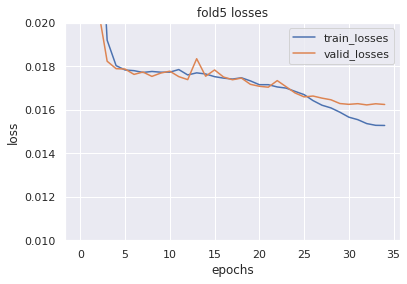

 
SEED : 5

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72641, train_metric: 0.72641
valid_loss: 0.70719, valid_metric: 0.70719
-----EPOCH2-----
train_loss: 0.69269, train_metric: 0.69268
valid_loss: 0.69828, valid_metric: 0.69828
-----EPOCH3-----
train_loss: 0.53128, train_metric: 0.53109
valid_loss: 0.26820, valid_metric: 0.26760
-----EPOCH4-----
train_loss: 0.06858, train_metric: 0.06685
valid_loss: 0.01217, valid_metric: 0.00942
-----EPOCH5-----
train_loss: 0.01111, train_metric: 0.00800
valid_loss: 0.01078, valid_metric: 0.00752
-----EPOCH6-----
train_loss: 0.01078, train_metric: 0.00753
valid_loss: 0.01069, valid_metric: 0.00742
-----EPOCH7-----
train_loss: 0.01081, train_metric: 0.00761
valid_loss: 0.01071, valid_metric: 0.00752
-----EPOCH8-----
train_loss: 0.01069, train_metric: 0.00752
valid_loss: 0.01069, valid_metric: 0.00752
-----EPOCH9-----
train_loss: 0.01065, train_metric: 0.00748
valid_loss: 0.01070, valid_metric: 0.00749
-----EPOCH10-----
tr

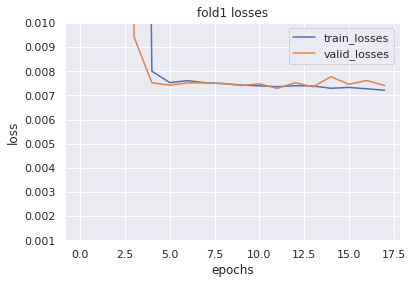

scored_loop
-----EPOCH1-----
train_loss: 0.61992, train_metric: 0.61982
valid_loss: 0.40566, valid_metric: 0.40530
-----EPOCH2-----
train_loss: 0.15775, train_metric: 0.15669
valid_loss: 0.05018, valid_metric: 0.04842
-----EPOCH3-----
train_loss: 0.02882, train_metric: 0.02662
valid_loss: 0.02401, valid_metric: 0.02149
-----EPOCH4-----
train_loss: 0.02196, train_metric: 0.01925
valid_loss: 0.02125, valid_metric: 0.01835
-----EPOCH5-----
train_loss: 0.02110, train_metric: 0.01816
valid_loss: 0.02073, valid_metric: 0.01760
-----EPOCH6-----
train_loss: 0.02079, train_metric: 0.01777
valid_loss: 0.02057, valid_metric: 0.01744
-----EPOCH7-----
train_loss: 0.02070, train_metric: 0.01765
valid_loss: 0.02095, valid_metric: 0.01769
-----EPOCH8-----
train_loss: 0.02078, train_metric: 0.01773
valid_loss: 0.02063, valid_metric: 0.01763
-----EPOCH9-----
train_loss: 0.02075, train_metric: 0.01769
valid_loss: 0.02082, valid_metric: 0.01781
-----EPOCH10-----
train_loss: 0.02074, train_metric: 0.01768


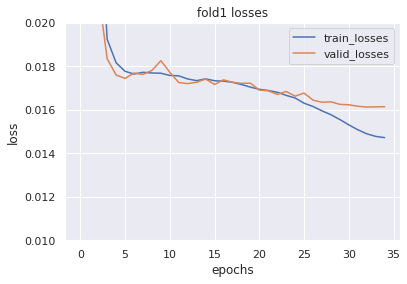

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72644, train_metric: 0.72643
valid_loss: 0.70636, valid_metric: 0.70636
-----EPOCH2-----
train_loss: 0.69260, train_metric: 0.69260
valid_loss: 0.69541, valid_metric: 0.69540
-----EPOCH3-----
train_loss: 0.53104, train_metric: 0.53084
valid_loss: 0.27099, valid_metric: 0.27040
-----EPOCH4-----
train_loss: 0.06841, train_metric: 0.06668
valid_loss: 0.01252, valid_metric: 0.00977
-----EPOCH5-----
train_loss: 0.01110, train_metric: 0.00799
valid_loss: 0.01112, valid_metric: 0.00782
-----EPOCH6-----
train_loss: 0.01074, train_metric: 0.00748
valid_loss: 0.01105, valid_metric: 0.00782
-----EPOCH7-----
train_loss: 0.01067, train_metric: 0.00747
valid_loss: 0.01105, valid_metric: 0.00782
-----EPOCH8-----
train_loss: 0.01061, train_metric: 0.00744
valid_loss: 0.01099, valid_metric: 0.00778
-----EPOCH9-----
train_loss: 0.01059, train_metric: 0.00742
valid_loss: 0.01112, valid_metric: 0.00787
-----EPOCH10-----
train_loss: 0.

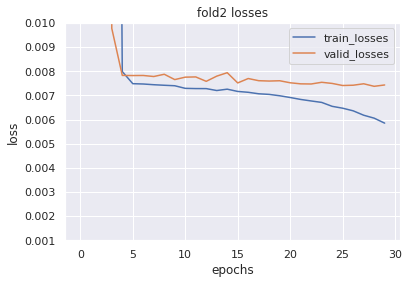

scored_loop
-----EPOCH1-----
train_loss: 0.59417, train_metric: 0.59405
valid_loss: 0.34782, valid_metric: 0.34737
-----EPOCH2-----
train_loss: 0.13759, train_metric: 0.13645
valid_loss: 0.04104, valid_metric: 0.03928
-----EPOCH3-----
train_loss: 0.02790, train_metric: 0.02568
valid_loss: 0.02344, valid_metric: 0.02100
-----EPOCH4-----
train_loss: 0.02178, train_metric: 0.01907
valid_loss: 0.02107, valid_metric: 0.01825
-----EPOCH5-----
train_loss: 0.02096, train_metric: 0.01804
valid_loss: 0.02069, valid_metric: 0.01756
-----EPOCH6-----
train_loss: 0.02082, train_metric: 0.01782
valid_loss: 0.02086, valid_metric: 0.01764
-----EPOCH7-----
train_loss: 0.02081, train_metric: 0.01777
valid_loss: 0.02077, valid_metric: 0.01763
-----EPOCH8-----
train_loss: 0.02085, train_metric: 0.01781
valid_loss: 0.02056, valid_metric: 0.01746
-----EPOCH9-----
train_loss: 0.02076, train_metric: 0.01771
valid_loss: 0.02105, valid_metric: 0.01796
-----EPOCH10-----
train_loss: 0.02085, train_metric: 0.01780


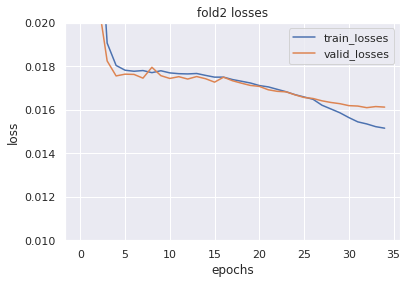

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72635, train_metric: 0.72635
valid_loss: 0.70651, valid_metric: 0.70651
-----EPOCH2-----
train_loss: 0.69258, train_metric: 0.69258
valid_loss: 0.69475, valid_metric: 0.69475
-----EPOCH3-----
train_loss: 0.53093, train_metric: 0.53073
valid_loss: 0.27258, valid_metric: 0.27199
-----EPOCH4-----
train_loss: 0.06843, train_metric: 0.06670
valid_loss: 0.01225, valid_metric: 0.00948
-----EPOCH5-----
train_loss: 0.01108, train_metric: 0.00797
valid_loss: 0.01092, valid_metric: 0.00762
-----EPOCH6-----
train_loss: 0.01074, train_metric: 0.00749
valid_loss: 0.01088, valid_metric: 0.00765
-----EPOCH7-----
train_loss: 0.01070, train_metric: 0.00750
valid_loss: 0.01085, valid_metric: 0.00768
-----EPOCH8-----
train_loss: 0.01062, train_metric: 0.00744
valid_loss: 0.01077, valid_metric: 0.00756
-----EPOCH9-----
train_loss: 0.01055, train_metric: 0.00738
valid_loss: 0.01077, valid_metric: 0.00753
-----EPOCH10-----
train_loss: 0.

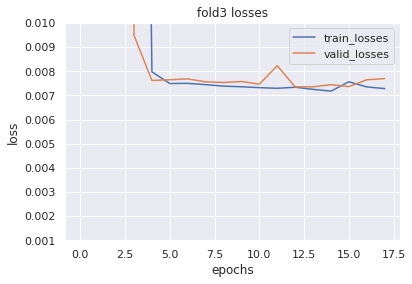

scored_loop
-----EPOCH1-----
train_loss: 0.60692, train_metric: 0.60680
valid_loss: 0.40876, valid_metric: 0.40837
-----EPOCH2-----
train_loss: 0.15365, train_metric: 0.15257
valid_loss: 0.04100, valid_metric: 0.03922
-----EPOCH3-----
train_loss: 0.02852, train_metric: 0.02632
valid_loss: 0.02329, valid_metric: 0.02081
-----EPOCH4-----
train_loss: 0.02192, train_metric: 0.01921
valid_loss: 0.02106, valid_metric: 0.01817
-----EPOCH5-----
train_loss: 0.02105, train_metric: 0.01811
valid_loss: 0.02079, valid_metric: 0.01783
-----EPOCH6-----
train_loss: 0.02090, train_metric: 0.01787
valid_loss: 0.02082, valid_metric: 0.01769
-----EPOCH7-----
train_loss: 0.02076, train_metric: 0.01771
valid_loss: 0.02060, valid_metric: 0.01741
-----EPOCH8-----
train_loss: 0.02063, train_metric: 0.01758
valid_loss: 0.02068, valid_metric: 0.01765
-----EPOCH9-----
train_loss: 0.02075, train_metric: 0.01770
valid_loss: 0.02088, valid_metric: 0.01784
-----EPOCH10-----
train_loss: 0.02079, train_metric: 0.01774


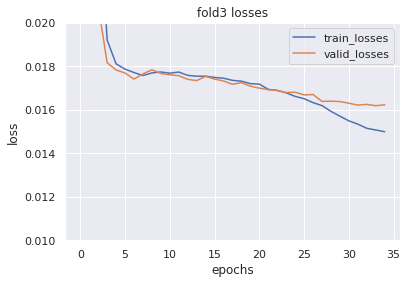

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72637, train_metric: 0.72637
valid_loss: 0.70630, valid_metric: 0.70630
-----EPOCH2-----
train_loss: 0.69259, train_metric: 0.69258
valid_loss: 0.69545, valid_metric: 0.69544
-----EPOCH3-----
train_loss: 0.53149, train_metric: 0.53129
valid_loss: 0.26706, valid_metric: 0.26646
-----EPOCH4-----
train_loss: 0.06859, train_metric: 0.06686
valid_loss: 0.01232, valid_metric: 0.00959
-----EPOCH5-----
train_loss: 0.01108, train_metric: 0.00797
valid_loss: 0.01075, valid_metric: 0.00745
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00754
valid_loss: 0.01070, valid_metric: 0.00741
-----EPOCH7-----
train_loss: 0.01069, train_metric: 0.00749
valid_loss: 0.01067, valid_metric: 0.00743
-----EPOCH8-----
train_loss: 0.01069, train_metric: 0.00752
valid_loss: 0.01063, valid_metric: 0.00740
-----EPOCH9-----
train_loss: 0.01060, train_metric: 0.00743
valid_loss: 0.01058, valid_metric: 0.00727
-----EPOCH10-----
train_loss: 0.

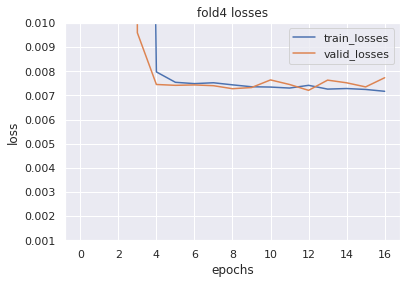

scored_loop
-----EPOCH1-----
train_loss: 0.61663, train_metric: 0.61652
valid_loss: 0.41949, valid_metric: 0.41913
-----EPOCH2-----
train_loss: 0.15869, train_metric: 0.15763
valid_loss: 0.04083, valid_metric: 0.03904
-----EPOCH3-----
train_loss: 0.02864, train_metric: 0.02643
valid_loss: 0.02342, valid_metric: 0.02095
-----EPOCH4-----
train_loss: 0.02189, train_metric: 0.01917
valid_loss: 0.02119, valid_metric: 0.01831
-----EPOCH5-----
train_loss: 0.02094, train_metric: 0.01800
valid_loss: 0.02069, valid_metric: 0.01755
-----EPOCH6-----
train_loss: 0.02081, train_metric: 0.01779
valid_loss: 0.02078, valid_metric: 0.01761
-----EPOCH7-----
train_loss: 0.02067, train_metric: 0.01763
valid_loss: 0.02051, valid_metric: 0.01736
-----EPOCH8-----
train_loss: 0.02073, train_metric: 0.01767
valid_loss: 0.02069, valid_metric: 0.01755
-----EPOCH9-----
train_loss: 0.02074, train_metric: 0.01768
valid_loss: 0.02089, valid_metric: 0.01784
-----EPOCH10-----
train_loss: 0.02073, train_metric: 0.01768


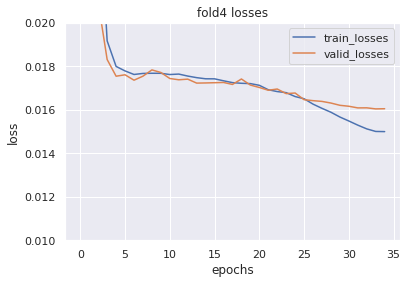

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72639, train_metric: 0.72639
valid_loss: 0.70677, valid_metric: 0.70677
-----EPOCH2-----
train_loss: 0.69258, train_metric: 0.69257
valid_loss: 0.69679, valid_metric: 0.69679
-----EPOCH3-----
train_loss: 0.53025, train_metric: 0.53006
valid_loss: 0.27129, valid_metric: 0.27070
-----EPOCH4-----
train_loss: 0.06792, train_metric: 0.06618
valid_loss: 0.01209, valid_metric: 0.00932
-----EPOCH5-----
train_loss: 0.01112, train_metric: 0.00801
valid_loss: 0.01077, valid_metric: 0.00755
-----EPOCH6-----
train_loss: 0.01078, train_metric: 0.00753
valid_loss: 0.01066, valid_metric: 0.00738
-----EPOCH7-----
train_loss: 0.01074, train_metric: 0.00754
valid_loss: 0.01066, valid_metric: 0.00740
-----EPOCH8-----
train_loss: 0.01072, train_metric: 0.00755
valid_loss: 0.01059, valid_metric: 0.00734
-----EPOCH9-----
train_loss: 0.01065, train_metric: 0.00748
valid_loss: 0.01060, valid_metric: 0.00739
-----EPOCH10-----
train_loss: 0.

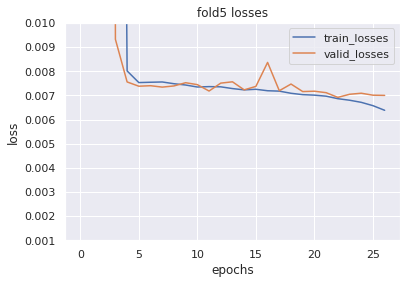

scored_loop
-----EPOCH1-----
train_loss: 0.59317, train_metric: 0.59305
valid_loss: 0.35604, valid_metric: 0.35560
-----EPOCH2-----
train_loss: 0.13927, train_metric: 0.13815
valid_loss: 0.03946, valid_metric: 0.03766
-----EPOCH3-----
train_loss: 0.02802, train_metric: 0.02581
valid_loss: 0.02328, valid_metric: 0.02080
-----EPOCH4-----
train_loss: 0.02185, train_metric: 0.01914
valid_loss: 0.02117, valid_metric: 0.01829
-----EPOCH5-----
train_loss: 0.02106, train_metric: 0.01815
valid_loss: 0.02096, valid_metric: 0.01802
-----EPOCH6-----
train_loss: 0.02077, train_metric: 0.01777
valid_loss: 0.02083, valid_metric: 0.01793
-----EPOCH7-----
train_loss: 0.02085, train_metric: 0.01782
valid_loss: 0.02092, valid_metric: 0.01792
-----EPOCH8-----
train_loss: 0.02086, train_metric: 0.01783
valid_loss: 0.02095, valid_metric: 0.01778
-----EPOCH9-----
train_loss: 0.02101, train_metric: 0.01797
valid_loss: 0.02188, valid_metric: 0.01885
-----EPOCH10-----
train_loss: 0.02085, train_metric: 0.01780


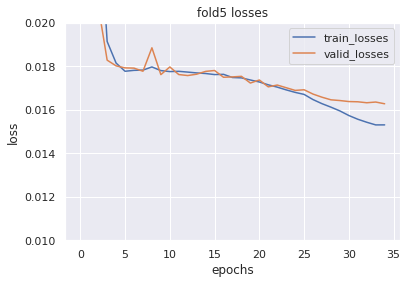

 
SEED : 6

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72475, train_metric: 0.72474
valid_loss: 0.70020, valid_metric: 0.70019
-----EPOCH2-----
train_loss: 0.69071, train_metric: 0.69070
valid_loss: 0.66694, valid_metric: 0.66691
-----EPOCH3-----
train_loss: 0.52519, train_metric: 0.52499
valid_loss: 0.23296, valid_metric: 0.23228
-----EPOCH4-----
train_loss: 0.06531, train_metric: 0.06356
valid_loss: 0.01199, valid_metric: 0.00920
-----EPOCH5-----
train_loss: 0.01108, train_metric: 0.00796
valid_loss: 0.01077, valid_metric: 0.00748
-----EPOCH6-----
train_loss: 0.01080, train_metric: 0.00754
valid_loss: 0.01087, valid_metric: 0.00775
-----EPOCH7-----
train_loss: 0.01077, train_metric: 0.00758
valid_loss: 0.01070, valid_metric: 0.00750
-----EPOCH8-----
train_loss: 0.01073, train_metric: 0.00757
valid_loss: 0.01071, valid_metric: 0.00753
-----EPOCH9-----
train_loss: 0.01071, train_metric: 0.00755
valid_loss: 0.01065, valid_metric: 0.00740
-----EPOCH10-----
tr

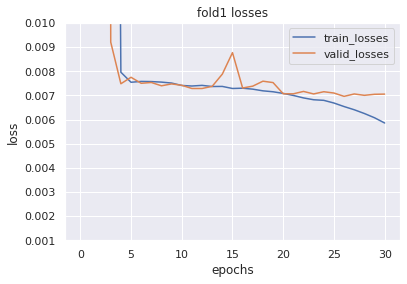

scored_loop
-----EPOCH1-----
train_loss: 0.59661, train_metric: 0.59649
valid_loss: 0.35226, valid_metric: 0.35181
-----EPOCH2-----
train_loss: 0.13829, train_metric: 0.13716
valid_loss: 0.04039, valid_metric: 0.03861
-----EPOCH3-----
train_loss: 0.02804, train_metric: 0.02583
valid_loss: 0.02307, valid_metric: 0.02058
-----EPOCH4-----
train_loss: 0.02189, train_metric: 0.01919
valid_loss: 0.02096, valid_metric: 0.01808
-----EPOCH5-----
train_loss: 0.02113, train_metric: 0.01822
valid_loss: 0.02083, valid_metric: 0.01782
-----EPOCH6-----
train_loss: 0.02087, train_metric: 0.01788
valid_loss: 0.02068, valid_metric: 0.01764
-----EPOCH7-----
train_loss: 0.02075, train_metric: 0.01773
valid_loss: 0.02068, valid_metric: 0.01762
-----EPOCH8-----
train_loss: 0.02090, train_metric: 0.01786
valid_loss: 0.02186, valid_metric: 0.01893
-----EPOCH9-----
train_loss: 0.02102, train_metric: 0.01799
valid_loss: 0.02078, valid_metric: 0.01776
-----EPOCH10-----
train_loss: 0.02097, train_metric: 0.01792


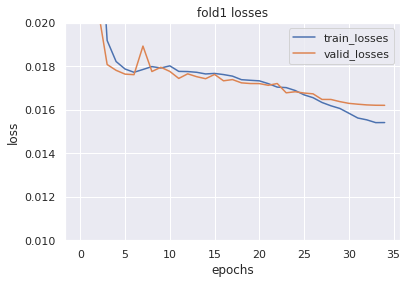

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72481, train_metric: 0.72481
valid_loss: 0.70029, valid_metric: 0.70029
-----EPOCH2-----
train_loss: 0.69073, train_metric: 0.69072
valid_loss: 0.66821, valid_metric: 0.66818
-----EPOCH3-----
train_loss: 0.52537, train_metric: 0.52516
valid_loss: 0.23799, valid_metric: 0.23733
-----EPOCH4-----
train_loss: 0.06546, train_metric: 0.06370
valid_loss: 0.01235, valid_metric: 0.00958
-----EPOCH5-----
train_loss: 0.01099, train_metric: 0.00787
valid_loss: 0.01109, valid_metric: 0.00782
-----EPOCH6-----
train_loss: 0.01071, train_metric: 0.00745
valid_loss: 0.01106, valid_metric: 0.00777
-----EPOCH7-----
train_loss: 0.01068, train_metric: 0.00748
valid_loss: 0.01107, valid_metric: 0.00792
-----EPOCH8-----
train_loss: 0.01067, train_metric: 0.00750
valid_loss: 0.01103, valid_metric: 0.00780
-----EPOCH9-----
train_loss: 0.01064, train_metric: 0.00748
valid_loss: 0.01126, valid_metric: 0.00823
-----EPOCH10-----
train_loss: 0.

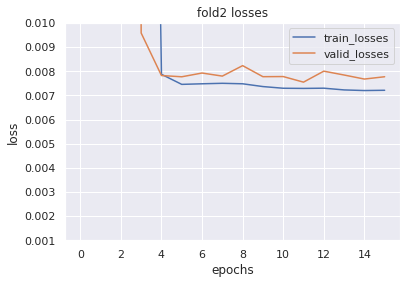

scored_loop
-----EPOCH1-----
train_loss: 0.62753, train_metric: 0.62744
valid_loss: 0.41347, valid_metric: 0.41311
-----EPOCH2-----
train_loss: 0.16479, train_metric: 0.16375
valid_loss: 0.04587, valid_metric: 0.04413
-----EPOCH3-----
train_loss: 0.02893, train_metric: 0.02674
valid_loss: 0.02320, valid_metric: 0.02070
-----EPOCH4-----
train_loss: 0.02191, train_metric: 0.01919
valid_loss: 0.02118, valid_metric: 0.01836
-----EPOCH5-----
train_loss: 0.02093, train_metric: 0.01799
valid_loss: 0.02105, valid_metric: 0.01792
-----EPOCH6-----
train_loss: 0.02069, train_metric: 0.01766
valid_loss: 0.02087, valid_metric: 0.01796
-----EPOCH7-----
train_loss: 0.02067, train_metric: 0.01762
valid_loss: 0.02088, valid_metric: 0.01785
-----EPOCH8-----
train_loss: 0.02075, train_metric: 0.01769
valid_loss: 0.02064, valid_metric: 0.01753
-----EPOCH9-----
train_loss: 0.02060, train_metric: 0.01754
valid_loss: 0.02047, valid_metric: 0.01741
-----EPOCH10-----
train_loss: 0.02063, train_metric: 0.01758


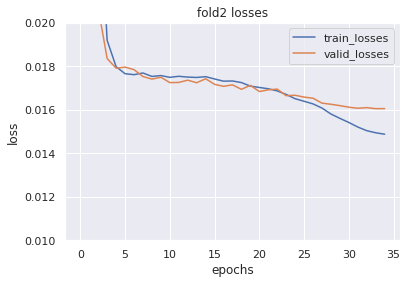

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72479, train_metric: 0.72478
valid_loss: 0.69950, valid_metric: 0.69949
-----EPOCH2-----
train_loss: 0.69078, train_metric: 0.69077
valid_loss: 0.66558, valid_metric: 0.66555
-----EPOCH3-----
train_loss: 0.52661, train_metric: 0.52640
valid_loss: 0.24579, valid_metric: 0.24514
-----EPOCH4-----
train_loss: 0.06629, train_metric: 0.06454
valid_loss: 0.01228, valid_metric: 0.00952
-----EPOCH5-----
train_loss: 0.01108, train_metric: 0.00796
valid_loss: 0.01095, valid_metric: 0.00771
-----EPOCH6-----
train_loss: 0.01077, train_metric: 0.00752
valid_loss: 0.01095, valid_metric: 0.00780
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00753
valid_loss: 0.01095, valid_metric: 0.00782
-----EPOCH8-----
train_loss: 0.01071, train_metric: 0.00754
valid_loss: 0.01082, valid_metric: 0.00756
-----EPOCH9-----
train_loss: 0.01065, train_metric: 0.00749
valid_loss: 0.01079, valid_metric: 0.00757
-----EPOCH10-----
train_loss: 0.

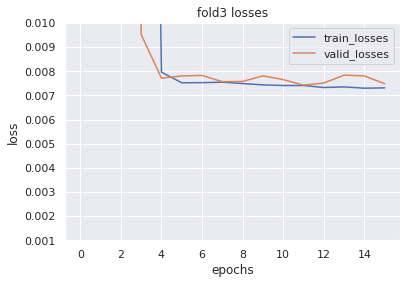

scored_loop
-----EPOCH1-----
train_loss: 0.62722, train_metric: 0.62713
valid_loss: 0.41212, valid_metric: 0.41177
-----EPOCH2-----
train_loss: 0.16428, train_metric: 0.16324
valid_loss: 0.04269, valid_metric: 0.04094
-----EPOCH3-----
train_loss: 0.02882, train_metric: 0.02663
valid_loss: 0.02261, valid_metric: 0.02004
-----EPOCH4-----
train_loss: 0.02191, train_metric: 0.01919
valid_loss: 0.02124, valid_metric: 0.01841
-----EPOCH5-----
train_loss: 0.02103, train_metric: 0.01809
valid_loss: 0.02058, valid_metric: 0.01757
-----EPOCH6-----
train_loss: 0.02084, train_metric: 0.01782
valid_loss: 0.02080, valid_metric: 0.01768
-----EPOCH7-----
train_loss: 0.02093, train_metric: 0.01789
valid_loss: 0.02105, valid_metric: 0.01808
-----EPOCH8-----
train_loss: 0.02080, train_metric: 0.01775
valid_loss: 0.02065, valid_metric: 0.01771
-----EPOCH9-----
train_loss: 0.02068, train_metric: 0.01763
valid_loss: 0.02054, valid_metric: 0.01739
-----EPOCH10-----
train_loss: 0.02074, train_metric: 0.01768


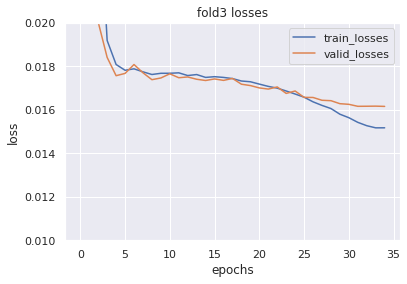

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72489, train_metric: 0.72489
valid_loss: 0.70016, valid_metric: 0.70015
-----EPOCH2-----
train_loss: 0.69090, train_metric: 0.69089
valid_loss: 0.66788, valid_metric: 0.66785
-----EPOCH3-----
train_loss: 0.52568, train_metric: 0.52548
valid_loss: 0.24184, valid_metric: 0.24118
-----EPOCH4-----
train_loss: 0.06564, train_metric: 0.06389
valid_loss: 0.01207, valid_metric: 0.00930
-----EPOCH5-----
train_loss: 0.01107, train_metric: 0.00795
valid_loss: 0.01079, valid_metric: 0.00758
-----EPOCH6-----
train_loss: 0.01076, train_metric: 0.00751
valid_loss: 0.01072, valid_metric: 0.00750
-----EPOCH7-----
train_loss: 0.01073, train_metric: 0.00753
valid_loss: 0.01069, valid_metric: 0.00744
-----EPOCH8-----
train_loss: 0.01069, train_metric: 0.00753
valid_loss: 0.01066, valid_metric: 0.00742
-----EPOCH9-----
train_loss: 0.01067, train_metric: 0.00751
valid_loss: 0.01084, valid_metric: 0.00774
-----EPOCH10-----
train_loss: 0.

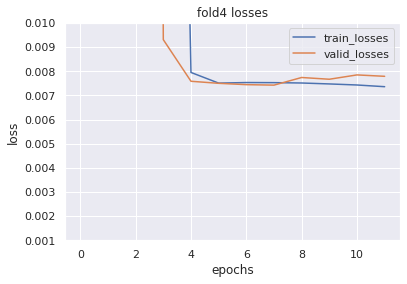

scored_loop
-----EPOCH1-----
train_loss: 0.63855, train_metric: 0.63847
valid_loss: 0.43275, valid_metric: 0.43243
-----EPOCH2-----
train_loss: 0.17352, train_metric: 0.17251
valid_loss: 0.04230, valid_metric: 0.04054
-----EPOCH3-----
train_loss: 0.02878, train_metric: 0.02658
valid_loss: 0.02252, valid_metric: 0.01993
-----EPOCH4-----
train_loss: 0.02192, train_metric: 0.01919
valid_loss: 0.02113, valid_metric: 0.01831
-----EPOCH5-----
train_loss: 0.02113, train_metric: 0.01818
valid_loss: 0.02094, valid_metric: 0.01792
-----EPOCH6-----
train_loss: 0.02096, train_metric: 0.01792
valid_loss: 0.02075, valid_metric: 0.01769
-----EPOCH7-----
train_loss: 0.02090, train_metric: 0.01784
valid_loss: 0.02141, valid_metric: 0.01838
-----EPOCH8-----
train_loss: 0.02088, train_metric: 0.01782
valid_loss: 0.02055, valid_metric: 0.01738
-----EPOCH9-----
train_loss: 0.02084, train_metric: 0.01779
valid_loss: 0.02091, valid_metric: 0.01778
-----EPOCH10-----
train_loss: 0.02087, train_metric: 0.01783


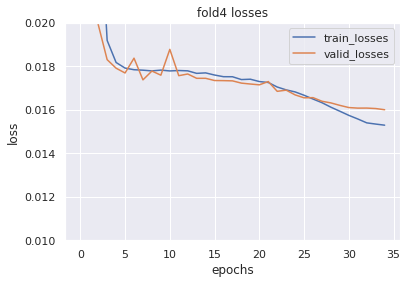

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72477, train_metric: 0.72477
valid_loss: 0.70081, valid_metric: 0.70080
-----EPOCH2-----
train_loss: 0.69075, train_metric: 0.69074
valid_loss: 0.66830, valid_metric: 0.66827
-----EPOCH3-----
train_loss: 0.52594, train_metric: 0.52574
valid_loss: 0.23573, valid_metric: 0.23506
-----EPOCH4-----
train_loss: 0.06581, train_metric: 0.06406
valid_loss: 0.01190, valid_metric: 0.00911
-----EPOCH5-----
train_loss: 0.01112, train_metric: 0.00800
valid_loss: 0.01073, valid_metric: 0.00749
-----EPOCH6-----
train_loss: 0.01082, train_metric: 0.00756
valid_loss: 0.01070, valid_metric: 0.00750
-----EPOCH7-----
train_loss: 0.01080, train_metric: 0.00761
valid_loss: 0.01077, valid_metric: 0.00766
-----EPOCH8-----
train_loss: 0.01072, train_metric: 0.00756
valid_loss: 0.01067, valid_metric: 0.00735
-----EPOCH9-----
train_loss: 0.01069, train_metric: 0.00753
valid_loss: 0.01069, valid_metric: 0.00739
-----EPOCH10-----
train_loss: 0.

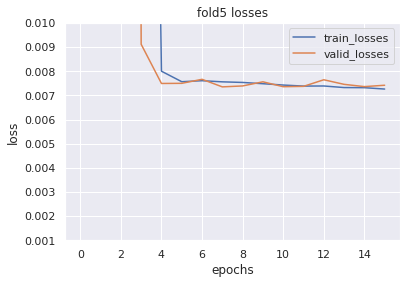

scored_loop
-----EPOCH1-----
train_loss: 0.62761, train_metric: 0.62752
valid_loss: 0.41666, valid_metric: 0.41630
-----EPOCH2-----
train_loss: 0.16393, train_metric: 0.16288
valid_loss: 0.04376, valid_metric: 0.04199
-----EPOCH3-----
train_loss: 0.02877, train_metric: 0.02658
valid_loss: 0.02365, valid_metric: 0.02108
-----EPOCH4-----
train_loss: 0.02186, train_metric: 0.01915
valid_loss: 0.02160, valid_metric: 0.01864
-----EPOCH5-----
train_loss: 0.02098, train_metric: 0.01804
valid_loss: 0.02085, valid_metric: 0.01782
-----EPOCH6-----
train_loss: 0.02072, train_metric: 0.01769
valid_loss: 0.02077, valid_metric: 0.01776
-----EPOCH7-----
train_loss: 0.02069, train_metric: 0.01763
valid_loss: 0.02052, valid_metric: 0.01750
-----EPOCH8-----
train_loss: 0.02052, train_metric: 0.01746
valid_loss: 0.02059, valid_metric: 0.01760
-----EPOCH9-----
train_loss: 0.02057, train_metric: 0.01750
valid_loss: 0.02054, valid_metric: 0.01748
-----EPOCH10-----
train_loss: 0.02054, train_metric: 0.01748


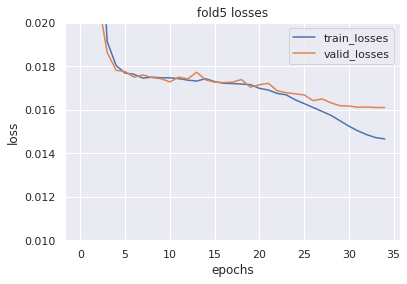

 
SEED : 7

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72763, train_metric: 0.72763
valid_loss: 0.70492, valid_metric: 0.70491
-----EPOCH2-----
train_loss: 0.69352, train_metric: 0.69351
valid_loss: 0.66087, valid_metric: 0.66083
-----EPOCH3-----
train_loss: 0.52598, train_metric: 0.52578
valid_loss: 0.22811, valid_metric: 0.22742
-----EPOCH4-----
train_loss: 0.06473, train_metric: 0.06297
valid_loss: 0.01209, valid_metric: 0.00933
-----EPOCH5-----
train_loss: 0.01105, train_metric: 0.00793
valid_loss: 0.01083, valid_metric: 0.00764
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00753
valid_loss: 0.01074, valid_metric: 0.00753
-----EPOCH7-----
train_loss: 0.01077, train_metric: 0.00757
valid_loss: 0.01078, valid_metric: 0.00763
-----EPOCH8-----
train_loss: 0.01074, train_metric: 0.00758
valid_loss: 0.01070, valid_metric: 0.00746
-----EPOCH9-----
train_loss: 0.01072, train_metric: 0.00757
valid_loss: 0.01078, valid_metric: 0.00761
-----EPOCH10-----
tr

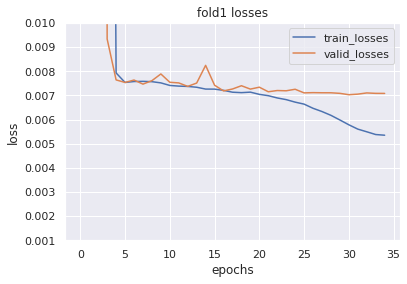

scored_loop
-----EPOCH1-----
train_loss: 0.59779, train_metric: 0.59767
valid_loss: 0.35904, valid_metric: 0.35860
-----EPOCH2-----
train_loss: 0.13750, train_metric: 0.13636
valid_loss: 0.03988, valid_metric: 0.03808
-----EPOCH3-----
train_loss: 0.02837, train_metric: 0.02617
valid_loss: 0.02300, valid_metric: 0.02047
-----EPOCH4-----
train_loss: 0.02210, train_metric: 0.01941
valid_loss: 0.02126, valid_metric: 0.01839
-----EPOCH5-----
train_loss: 0.02119, train_metric: 0.01829
valid_loss: 0.02087, valid_metric: 0.01789
-----EPOCH6-----
train_loss: 0.02095, train_metric: 0.01797
valid_loss: 0.02074, valid_metric: 0.01766
-----EPOCH7-----
train_loss: 0.02085, train_metric: 0.01782
valid_loss: 0.02064, valid_metric: 0.01761
-----EPOCH8-----
train_loss: 0.02088, train_metric: 0.01785
valid_loss: 0.02078, valid_metric: 0.01780
-----EPOCH9-----
train_loss: 0.02088, train_metric: 0.01784
valid_loss: 0.02099, valid_metric: 0.01792
-----EPOCH10-----
train_loss: 0.02083, train_metric: 0.01778


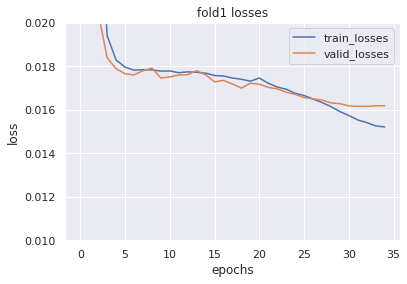

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72755, train_metric: 0.72755
valid_loss: 0.70499, valid_metric: 0.70499
-----EPOCH2-----
train_loss: 0.69340, train_metric: 0.69339
valid_loss: 0.65695, valid_metric: 0.65691
-----EPOCH3-----
train_loss: 0.52665, train_metric: 0.52644
valid_loss: 0.23237, valid_metric: 0.23168
-----EPOCH4-----
train_loss: 0.06545, train_metric: 0.06370
valid_loss: 0.01234, valid_metric: 0.00956
-----EPOCH5-----
train_loss: 0.01102, train_metric: 0.00790
valid_loss: 0.01113, valid_metric: 0.00789
-----EPOCH6-----
train_loss: 0.01071, train_metric: 0.00746
valid_loss: 0.01109, valid_metric: 0.00789
-----EPOCH7-----
train_loss: 0.01071, train_metric: 0.00751
valid_loss: 0.01118, valid_metric: 0.00811
-----EPOCH8-----
train_loss: 0.01065, train_metric: 0.00748
valid_loss: 0.01113, valid_metric: 0.00802
-----EPOCH9-----
train_loss: 0.01058, train_metric: 0.00742
valid_loss: 0.01105, valid_metric: 0.00788
-----EPOCH10-----
train_loss: 0.

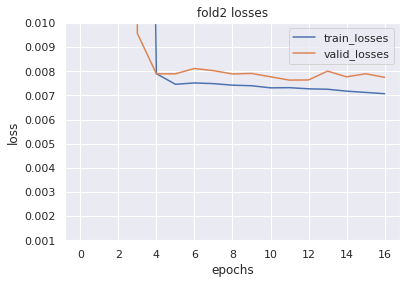

scored_loop
-----EPOCH1-----
train_loss: 0.61980, train_metric: 0.61969
valid_loss: 0.40826, valid_metric: 0.40788
-----EPOCH2-----
train_loss: 0.15986, train_metric: 0.15880
valid_loss: 0.04167, valid_metric: 0.03990
-----EPOCH3-----
train_loss: 0.02868, train_metric: 0.02648
valid_loss: 0.02327, valid_metric: 0.02076
-----EPOCH4-----
train_loss: 0.02189, train_metric: 0.01917
valid_loss: 0.02111, valid_metric: 0.01832
-----EPOCH5-----
train_loss: 0.02092, train_metric: 0.01798
valid_loss: 0.02069, valid_metric: 0.01760
-----EPOCH6-----
train_loss: 0.02078, train_metric: 0.01775
valid_loss: 0.02069, valid_metric: 0.01770
-----EPOCH7-----
train_loss: 0.02074, train_metric: 0.01769
valid_loss: 0.02048, valid_metric: 0.01746
-----EPOCH8-----
train_loss: 0.02061, train_metric: 0.01755
valid_loss: 0.02078, valid_metric: 0.01768
-----EPOCH9-----
train_loss: 0.02066, train_metric: 0.01760
valid_loss: 0.02068, valid_metric: 0.01757
-----EPOCH10-----
train_loss: 0.02063, train_metric: 0.01757


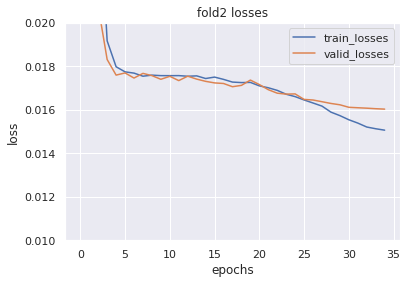

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72756, train_metric: 0.72756
valid_loss: 0.70553, valid_metric: 0.70553
-----EPOCH2-----
train_loss: 0.69359, train_metric: 0.69358
valid_loss: 0.66148, valid_metric: 0.66144
-----EPOCH3-----
train_loss: 0.52583, train_metric: 0.52563
valid_loss: 0.22854, valid_metric: 0.22785
-----EPOCH4-----
train_loss: 0.06469, train_metric: 0.06293
valid_loss: 0.01217, valid_metric: 0.00939
-----EPOCH5-----
train_loss: 0.01103, train_metric: 0.00791
valid_loss: 0.01094, valid_metric: 0.00771
-----EPOCH6-----
train_loss: 0.01073, train_metric: 0.00747
valid_loss: 0.01092, valid_metric: 0.00777
-----EPOCH7-----
train_loss: 0.01069, train_metric: 0.00749
valid_loss: 0.01087, valid_metric: 0.00770
-----EPOCH8-----
train_loss: 0.01069, train_metric: 0.00752
valid_loss: 0.01088, valid_metric: 0.00775
-----EPOCH9-----
train_loss: 0.01061, train_metric: 0.00745
valid_loss: 0.01103, valid_metric: 0.00801
-----EPOCH10-----
train_loss: 0.

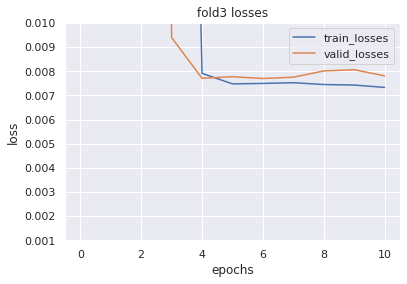

scored_loop
-----EPOCH1-----
train_loss: 0.63635, train_metric: 0.63626
valid_loss: 0.43229, valid_metric: 0.43196
-----EPOCH2-----
train_loss: 0.17342, train_metric: 0.17240
valid_loss: 0.04228, valid_metric: 0.04052
-----EPOCH3-----
train_loss: 0.02871, train_metric: 0.02650
valid_loss: 0.02310, valid_metric: 0.02058
-----EPOCH4-----
train_loss: 0.02202, train_metric: 0.01928
valid_loss: 0.02131, valid_metric: 0.01847
-----EPOCH5-----
train_loss: 0.02116, train_metric: 0.01821
valid_loss: 0.02095, valid_metric: 0.01790
-----EPOCH6-----
train_loss: 0.02100, train_metric: 0.01797
valid_loss: 0.02112, valid_metric: 0.01815
-----EPOCH7-----
train_loss: 0.02095, train_metric: 0.01789
valid_loss: 0.02087, valid_metric: 0.01773
-----EPOCH8-----
train_loss: 0.02086, train_metric: 0.01780
valid_loss: 0.02059, valid_metric: 0.01756
-----EPOCH9-----
train_loss: 0.02088, train_metric: 0.01783
valid_loss: 0.02054, valid_metric: 0.01747
-----EPOCH10-----
train_loss: 0.02094, train_metric: 0.01789


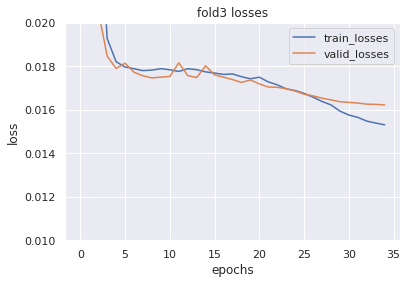

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72751, train_metric: 0.72752
valid_loss: 0.70541, valid_metric: 0.70541
-----EPOCH2-----
train_loss: 0.69356, train_metric: 0.69355
valid_loss: 0.65898, valid_metric: 0.65894
-----EPOCH3-----
train_loss: 0.52571, train_metric: 0.52550
valid_loss: 0.22667, valid_metric: 0.22597
-----EPOCH4-----
train_loss: 0.06466, train_metric: 0.06290
valid_loss: 0.01201, valid_metric: 0.00923
-----EPOCH5-----
train_loss: 0.01107, train_metric: 0.00795
valid_loss: 0.01080, valid_metric: 0.00754
-----EPOCH6-----
train_loss: 0.01077, train_metric: 0.00752
valid_loss: 0.01079, valid_metric: 0.00764
-----EPOCH7-----
train_loss: 0.01077, train_metric: 0.00758
valid_loss: 0.01083, valid_metric: 0.00774
-----EPOCH8-----
train_loss: 0.01071, train_metric: 0.00755
valid_loss: 0.01092, valid_metric: 0.00787
-----EPOCH9-----
train_loss: 0.01066, train_metric: 0.00751
valid_loss: 0.01075, valid_metric: 0.00762
-----EPOCH10-----
train_loss: 0.

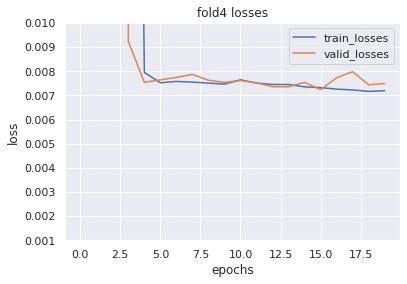

scored_loop
-----EPOCH1-----
train_loss: 0.61229, train_metric: 0.61218
valid_loss: 0.39600, valid_metric: 0.39562
-----EPOCH2-----
train_loss: 0.15449, train_metric: 0.15342
valid_loss: 0.04126, valid_metric: 0.03948
-----EPOCH3-----
train_loss: 0.02882, train_metric: 0.02663
valid_loss: 0.02264, valid_metric: 0.02006
-----EPOCH4-----
train_loss: 0.02205, train_metric: 0.01935
valid_loss: 0.02267, valid_metric: 0.01984
-----EPOCH5-----
train_loss: 0.02115, train_metric: 0.01823
valid_loss: 0.02081, valid_metric: 0.01781
-----EPOCH6-----
train_loss: 0.02097, train_metric: 0.01797
valid_loss: 0.02103, valid_metric: 0.01807
-----EPOCH7-----
train_loss: 0.02105, train_metric: 0.01802
valid_loss: 0.02087, valid_metric: 0.01777
-----EPOCH8-----
train_loss: 0.02083, train_metric: 0.01780
valid_loss: 0.02063, valid_metric: 0.01750
-----EPOCH9-----
train_loss: 0.02079, train_metric: 0.01774
valid_loss: 0.02051, valid_metric: 0.01743
-----EPOCH10-----
train_loss: 0.02069, train_metric: 0.01764


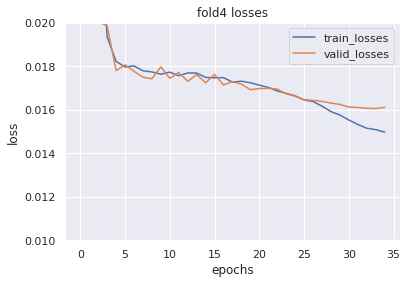

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72757, train_metric: 0.72757
valid_loss: 0.70429, valid_metric: 0.70429
-----EPOCH2-----
train_loss: 0.69350, train_metric: 0.69350
valid_loss: 0.65951, valid_metric: 0.65947
-----EPOCH3-----
train_loss: 0.52618, train_metric: 0.52598
valid_loss: 0.23254, valid_metric: 0.23186
-----EPOCH4-----
train_loss: 0.06498, train_metric: 0.06322
valid_loss: 0.01210, valid_metric: 0.00934
-----EPOCH5-----
train_loss: 0.01113, train_metric: 0.00801
valid_loss: 0.01074, valid_metric: 0.00751
-----EPOCH6-----
train_loss: 0.01086, train_metric: 0.00761
valid_loss: 0.01075, valid_metric: 0.00758
-----EPOCH7-----
train_loss: 0.01078, train_metric: 0.00759
valid_loss: 0.01071, valid_metric: 0.00751
-----EPOCH8-----
train_loss: 0.01075, train_metric: 0.00759
valid_loss: 0.01067, valid_metric: 0.00749
-----EPOCH9-----
train_loss: 0.01070, train_metric: 0.00754
valid_loss: 0.01072, valid_metric: 0.00761
-----EPOCH10-----
train_loss: 0.

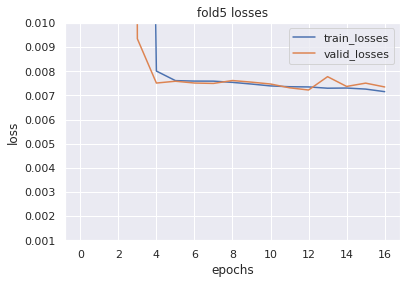

scored_loop
-----EPOCH1-----
train_loss: 0.61206, train_metric: 0.61194
valid_loss: 0.40619, valid_metric: 0.40581
-----EPOCH2-----
train_loss: 0.15894, train_metric: 0.15788
valid_loss: 0.04281, valid_metric: 0.04105
-----EPOCH3-----
train_loss: 0.02863, train_metric: 0.02643
valid_loss: 0.02288, valid_metric: 0.02035
-----EPOCH4-----
train_loss: 0.02180, train_metric: 0.01909
valid_loss: 0.02093, valid_metric: 0.01800
-----EPOCH5-----
train_loss: 0.02090, train_metric: 0.01796
valid_loss: 0.02088, valid_metric: 0.01785
-----EPOCH6-----
train_loss: 0.02069, train_metric: 0.01767
valid_loss: 0.02102, valid_metric: 0.01800
-----EPOCH7-----
train_loss: 0.02064, train_metric: 0.01759
valid_loss: 0.02084, valid_metric: 0.01779
-----EPOCH8-----
train_loss: 0.02067, train_metric: 0.01762
valid_loss: 0.02061, valid_metric: 0.01753
-----EPOCH9-----
train_loss: 0.02067, train_metric: 0.01762
valid_loss: 0.02094, valid_metric: 0.01776
-----EPOCH10-----
train_loss: 0.02072, train_metric: 0.01767


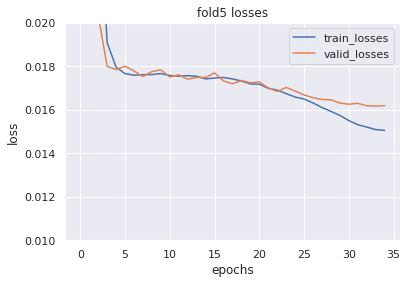

 
SEED : 8

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72614, train_metric: 0.72614
valid_loss: 0.70321, valid_metric: 0.70321
-----EPOCH2-----
train_loss: 0.69189, train_metric: 0.69188
valid_loss: 0.68687, valid_metric: 0.68685
-----EPOCH3-----
train_loss: 0.52519, train_metric: 0.52499
valid_loss: 0.24682, valid_metric: 0.24617
-----EPOCH4-----
train_loss: 0.06491, train_metric: 0.06314
valid_loss: 0.01206, valid_metric: 0.00928
-----EPOCH5-----
train_loss: 0.01107, train_metric: 0.00794
valid_loss: 0.01079, valid_metric: 0.00751
-----EPOCH6-----
train_loss: 0.01080, train_metric: 0.00755
valid_loss: 0.01072, valid_metric: 0.00744
-----EPOCH7-----
train_loss: 0.01076, train_metric: 0.00757
valid_loss: 0.01069, valid_metric: 0.00745
-----EPOCH8-----
train_loss: 0.01073, train_metric: 0.00757
valid_loss: 0.01074, valid_metric: 0.00760
-----EPOCH9-----
train_loss: 0.01072, train_metric: 0.00756
valid_loss: 0.01085, valid_metric: 0.00773
-----EPOCH10-----
tr

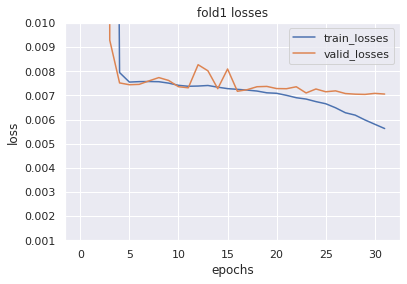

scored_loop
-----EPOCH1-----
train_loss: 0.59828, train_metric: 0.59816
valid_loss: 0.35480, valid_metric: 0.35435
-----EPOCH2-----
train_loss: 0.13791, train_metric: 0.13678
valid_loss: 0.03972, valid_metric: 0.03792
-----EPOCH3-----
train_loss: 0.02819, train_metric: 0.02598
valid_loss: 0.02288, valid_metric: 0.02034
-----EPOCH4-----
train_loss: 0.02197, train_metric: 0.01927
valid_loss: 0.02117, valid_metric: 0.01835
-----EPOCH5-----
train_loss: 0.02109, train_metric: 0.01818
valid_loss: 0.02106, valid_metric: 0.01818
-----EPOCH6-----
train_loss: 0.02096, train_metric: 0.01796
valid_loss: 0.02118, valid_metric: 0.01823
-----EPOCH7-----
train_loss: 0.02087, train_metric: 0.01785
valid_loss: 0.02125, valid_metric: 0.01817
-----EPOCH8-----
train_loss: 0.02089, train_metric: 0.01786
valid_loss: 0.02056, valid_metric: 0.01751
-----EPOCH9-----
train_loss: 0.02083, train_metric: 0.01779
valid_loss: 0.02087, valid_metric: 0.01780
-----EPOCH10-----
train_loss: 0.02084, train_metric: 0.01780


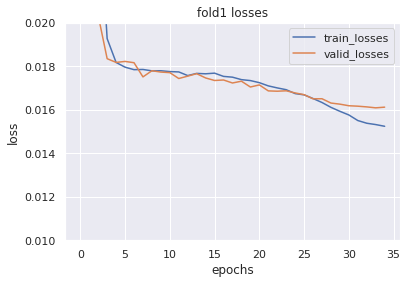

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72616, train_metric: 0.72615
valid_loss: 0.70240, valid_metric: 0.70240
-----EPOCH2-----
train_loss: 0.69199, train_metric: 0.69198
valid_loss: 0.68580, valid_metric: 0.68579
-----EPOCH3-----
train_loss: 0.52417, train_metric: 0.52396
valid_loss: 0.24580, valid_metric: 0.24515
-----EPOCH4-----
train_loss: 0.06419, train_metric: 0.06242
valid_loss: 0.01229, valid_metric: 0.00951
-----EPOCH5-----
train_loss: 0.01104, train_metric: 0.00791
valid_loss: 0.01111, valid_metric: 0.00784
-----EPOCH6-----
train_loss: 0.01071, train_metric: 0.00746
valid_loss: 0.01108, valid_metric: 0.00787
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00752
valid_loss: 0.01106, valid_metric: 0.00787
-----EPOCH8-----
train_loss: 0.01070, train_metric: 0.00754
valid_loss: 0.01108, valid_metric: 0.00789
-----EPOCH9-----
train_loss: 0.01065, train_metric: 0.00749
valid_loss: 0.01101, valid_metric: 0.00781
-----EPOCH10-----
train_loss: 0.

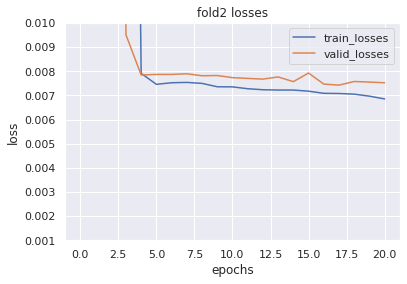

scored_loop
-----EPOCH1-----
train_loss: 0.59936, train_metric: 0.59924
valid_loss: 0.37384, valid_metric: 0.37343
-----EPOCH2-----
train_loss: 0.14762, train_metric: 0.14652
valid_loss: 0.04015, valid_metric: 0.03836
-----EPOCH3-----
train_loss: 0.02820, train_metric: 0.02600
valid_loss: 0.02224, valid_metric: 0.01965
-----EPOCH4-----
train_loss: 0.02170, train_metric: 0.01899
valid_loss: 0.02103, valid_metric: 0.01810
-----EPOCH5-----
train_loss: 0.02101, train_metric: 0.01808
valid_loss: 0.02070, valid_metric: 0.01775
-----EPOCH6-----
train_loss: 0.02085, train_metric: 0.01784
valid_loss: 0.02078, valid_metric: 0.01780
-----EPOCH7-----
train_loss: 0.02082, train_metric: 0.01778
valid_loss: 0.02073, valid_metric: 0.01753
-----EPOCH8-----
train_loss: 0.02078, train_metric: 0.01774
valid_loss: 0.02066, valid_metric: 0.01763
-----EPOCH9-----
train_loss: 0.02088, train_metric: 0.01783
valid_loss: 0.02057, valid_metric: 0.01750
-----EPOCH10-----
train_loss: 0.02082, train_metric: 0.01777


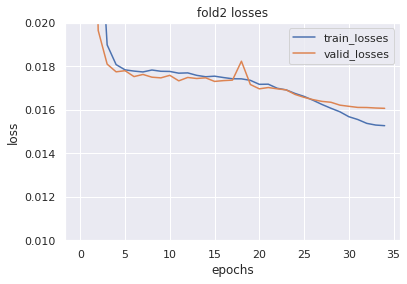

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72612, train_metric: 0.72612
valid_loss: 0.70217, valid_metric: 0.70217
-----EPOCH2-----
train_loss: 0.69170, train_metric: 0.69169
valid_loss: 0.68046, valid_metric: 0.68044
-----EPOCH3-----
train_loss: 0.52503, train_metric: 0.52482
valid_loss: 0.24481, valid_metric: 0.24416
-----EPOCH4-----
train_loss: 0.06460, train_metric: 0.06284
valid_loss: 0.01208, valid_metric: 0.00928
-----EPOCH5-----
train_loss: 0.01109, train_metric: 0.00797
valid_loss: 0.01096, valid_metric: 0.00768
-----EPOCH6-----
train_loss: 0.01071, train_metric: 0.00745
valid_loss: 0.01103, valid_metric: 0.00792
-----EPOCH7-----
train_loss: 0.01071, train_metric: 0.00751
valid_loss: 0.01096, valid_metric: 0.00783
-----EPOCH8-----
train_loss: 0.01068, train_metric: 0.00752
valid_loss: 0.01084, valid_metric: 0.00768
-----EPOCH9-----
train_loss: 0.01064, train_metric: 0.00747
valid_loss: 0.01091, valid_metric: 0.00776
-----EPOCH10-----
train_loss: 0.

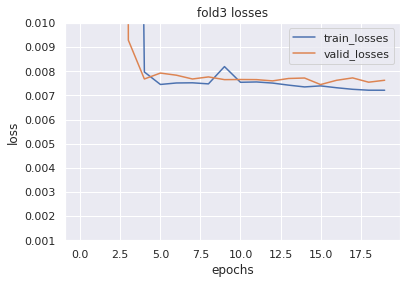

scored_loop
-----EPOCH1-----
train_loss: 0.61529, train_metric: 0.61518
valid_loss: 0.40012, valid_metric: 0.39973
-----EPOCH2-----
train_loss: 0.15677, train_metric: 0.15570
valid_loss: 0.04530, valid_metric: 0.04350
-----EPOCH3-----
train_loss: 0.02988, train_metric: 0.02769
valid_loss: 0.02519, valid_metric: 0.02262
-----EPOCH4-----
train_loss: 0.02283, train_metric: 0.02014
valid_loss: 0.02184, valid_metric: 0.01909
-----EPOCH5-----
train_loss: 0.02159, train_metric: 0.01868
valid_loss: 0.02130, valid_metric: 0.01842
-----EPOCH6-----
train_loss: 0.02120, train_metric: 0.01821
valid_loss: 0.02080, valid_metric: 0.01765
-----EPOCH7-----
train_loss: 0.02095, train_metric: 0.01792
valid_loss: 0.02074, valid_metric: 0.01762
-----EPOCH8-----
train_loss: 0.02089, train_metric: 0.01785
valid_loss: 0.02090, valid_metric: 0.01795
-----EPOCH9-----
train_loss: 0.02092, train_metric: 0.01788
valid_loss: 0.02096, valid_metric: 0.01789
-----EPOCH10-----
train_loss: 0.02069, train_metric: 0.01763


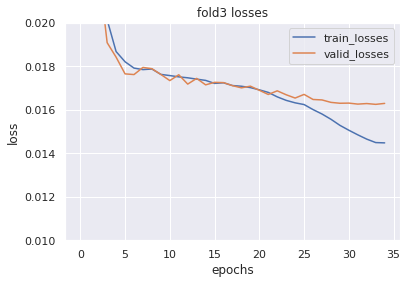

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72613, train_metric: 0.72612
valid_loss: 0.70266, valid_metric: 0.70265
-----EPOCH2-----
train_loss: 0.69191, train_metric: 0.69190
valid_loss: 0.68359, valid_metric: 0.68357
-----EPOCH3-----
train_loss: 0.52366, train_metric: 0.52345
valid_loss: 0.24298, valid_metric: 0.24233
-----EPOCH4-----
train_loss: 0.06381, train_metric: 0.06203
valid_loss: 0.01197, valid_metric: 0.00919
-----EPOCH5-----
train_loss: 0.01105, train_metric: 0.00792
valid_loss: 0.01077, valid_metric: 0.00746
-----EPOCH6-----
train_loss: 0.01076, train_metric: 0.00750
valid_loss: 0.01072, valid_metric: 0.00749
-----EPOCH7-----
train_loss: 0.01073, train_metric: 0.00753
valid_loss: 0.01070, valid_metric: 0.00750
-----EPOCH8-----
train_loss: 0.01068, train_metric: 0.00751
valid_loss: 0.01083, valid_metric: 0.00775
-----EPOCH9-----
train_loss: 0.01067, train_metric: 0.00750
valid_loss: 0.01072, valid_metric: 0.00756
-----EPOCH10-----
train_loss: 0.

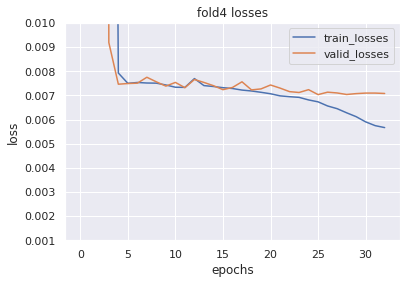

scored_loop
-----EPOCH1-----
train_loss: 0.59808, train_metric: 0.59796
valid_loss: 0.35953, valid_metric: 0.35909
-----EPOCH2-----
train_loss: 0.13825, train_metric: 0.13711
valid_loss: 0.04006, valid_metric: 0.03826
-----EPOCH3-----
train_loss: 0.02811, train_metric: 0.02591
valid_loss: 0.02260, valid_metric: 0.02003
-----EPOCH4-----
train_loss: 0.02187, train_metric: 0.01917
valid_loss: 0.02205, valid_metric: 0.01942
-----EPOCH5-----
train_loss: 0.02108, train_metric: 0.01816
valid_loss: 0.02071, valid_metric: 0.01773
-----EPOCH6-----
train_loss: 0.02094, train_metric: 0.01794
valid_loss: 0.02086, valid_metric: 0.01797
-----EPOCH7-----
train_loss: 0.02093, train_metric: 0.01791
valid_loss: 0.02098, valid_metric: 0.01785
-----EPOCH8-----
train_loss: 0.02091, train_metric: 0.01787
valid_loss: 0.02079, valid_metric: 0.01780
-----EPOCH9-----
train_loss: 0.02082, train_metric: 0.01778
valid_loss: 0.02118, valid_metric: 0.01792
-----EPOCH10-----
train_loss: 0.02080, train_metric: 0.01774


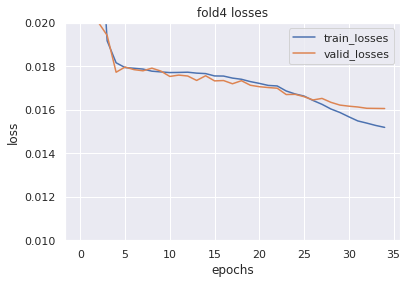

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72610, train_metric: 0.72610
valid_loss: 0.70204, valid_metric: 0.70204
-----EPOCH2-----
train_loss: 0.69179, train_metric: 0.69178
valid_loss: 0.68262, valid_metric: 0.68261
-----EPOCH3-----
train_loss: 0.52494, train_metric: 0.52473
valid_loss: 0.24343, valid_metric: 0.24277
-----EPOCH4-----
train_loss: 0.06464, train_metric: 0.06287
valid_loss: 0.01202, valid_metric: 0.00925
-----EPOCH5-----
train_loss: 0.01113, train_metric: 0.00801
valid_loss: 0.01072, valid_metric: 0.00744
-----EPOCH6-----
train_loss: 0.01081, train_metric: 0.00756
valid_loss: 0.01066, valid_metric: 0.00740
-----EPOCH7-----
train_loss: 0.01080, train_metric: 0.00761
valid_loss: 0.01068, valid_metric: 0.00747
-----EPOCH8-----
train_loss: 0.01079, train_metric: 0.00763
valid_loss: 0.01069, valid_metric: 0.00753
-----EPOCH9-----
train_loss: 0.01072, train_metric: 0.00756
valid_loss: 0.01061, valid_metric: 0.00741
-----EPOCH10-----
train_loss: 0.

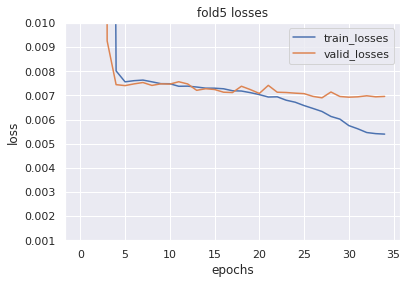

scored_loop
-----EPOCH1-----
train_loss: 0.59296, train_metric: 0.59284
valid_loss: 0.35246, valid_metric: 0.35202
-----EPOCH2-----
train_loss: 0.13559, train_metric: 0.13445
valid_loss: 0.03855, valid_metric: 0.03673
-----EPOCH3-----
train_loss: 0.02798, train_metric: 0.02577
valid_loss: 0.02308, valid_metric: 0.02058
-----EPOCH4-----
train_loss: 0.02187, train_metric: 0.01917
valid_loss: 0.02137, valid_metric: 0.01857
-----EPOCH5-----
train_loss: 0.02097, train_metric: 0.01806
valid_loss: 0.02087, valid_metric: 0.01779
-----EPOCH6-----
train_loss: 0.02087, train_metric: 0.01787
valid_loss: 0.02129, valid_metric: 0.01809
-----EPOCH7-----
train_loss: 0.02101, train_metric: 0.01799
valid_loss: 0.02084, valid_metric: 0.01786
-----EPOCH8-----
train_loss: 0.02093, train_metric: 0.01790
valid_loss: 0.02130, valid_metric: 0.01818
-----EPOCH9-----
train_loss: 0.02084, train_metric: 0.01779
valid_loss: 0.02098, valid_metric: 0.01801
-----EPOCH10-----
train_loss: 0.02082, train_metric: 0.01777


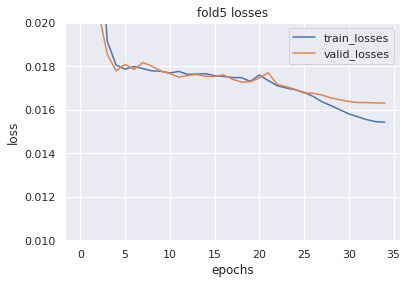

 
SEED : 9

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72814, train_metric: 0.72814
valid_loss: 0.70148, valid_metric: 0.70147
-----EPOCH2-----
train_loss: 0.69407, train_metric: 0.69406
valid_loss: 0.67811, valid_metric: 0.67809
-----EPOCH3-----
train_loss: 0.52597, train_metric: 0.52577
valid_loss: 0.24719, valid_metric: 0.24655
-----EPOCH4-----
train_loss: 0.06455, train_metric: 0.06278
valid_loss: 0.01197, valid_metric: 0.00918
-----EPOCH5-----
train_loss: 0.01108, train_metric: 0.00796
valid_loss: 0.01078, valid_metric: 0.00754
-----EPOCH6-----
train_loss: 0.01078, train_metric: 0.00752
valid_loss: 0.01076, valid_metric: 0.00756
-----EPOCH7-----
train_loss: 0.01077, train_metric: 0.00757
valid_loss: 0.01077, valid_metric: 0.00765
-----EPOCH8-----
train_loss: 0.01074, train_metric: 0.00758
valid_loss: 0.01068, valid_metric: 0.00750
-----EPOCH9-----
train_loss: 0.01066, train_metric: 0.00749
valid_loss: 0.01069, valid_metric: 0.00751
-----EPOCH10-----
tr

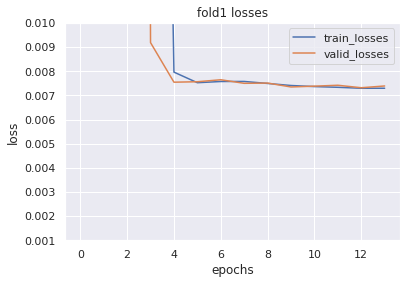

scored_loop
-----EPOCH1-----
train_loss: 0.62066, train_metric: 0.62056
valid_loss: 0.41556, valid_metric: 0.41520
-----EPOCH2-----
train_loss: 0.16414, train_metric: 0.16310
valid_loss: 0.04202, valid_metric: 0.04025
-----EPOCH3-----
train_loss: 0.02879, train_metric: 0.02659
valid_loss: 0.02287, valid_metric: 0.02033
-----EPOCH4-----
train_loss: 0.02194, train_metric: 0.01922
valid_loss: 0.02127, valid_metric: 0.01845
-----EPOCH5-----
train_loss: 0.02098, train_metric: 0.01803
valid_loss: 0.02096, valid_metric: 0.01775
-----EPOCH6-----
train_loss: 0.02084, train_metric: 0.01780
valid_loss: 0.02102, valid_metric: 0.01777
-----EPOCH7-----
train_loss: 0.02082, train_metric: 0.01776
valid_loss: 0.02080, valid_metric: 0.01764
-----EPOCH8-----
train_loss: 0.02072, train_metric: 0.01767
valid_loss: 0.02091, valid_metric: 0.01769
-----EPOCH9-----
train_loss: 0.02070, train_metric: 0.01764
valid_loss: 0.02085, valid_metric: 0.01774
-----EPOCH10-----
train_loss: 0.02084, train_metric: 0.01779


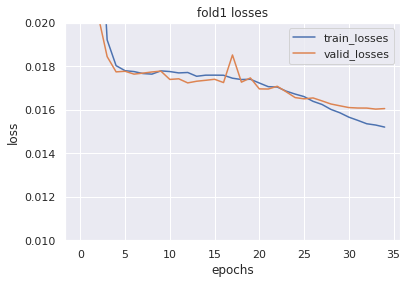

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72815, train_metric: 0.72815
valid_loss: 0.70156, valid_metric: 0.70156
-----EPOCH2-----
train_loss: 0.69407, train_metric: 0.69406
valid_loss: 0.67663, valid_metric: 0.67660
-----EPOCH3-----
train_loss: 0.52676, train_metric: 0.52656
valid_loss: 0.24747, valid_metric: 0.24683
-----EPOCH4-----
train_loss: 0.06501, train_metric: 0.06325
valid_loss: 0.01233, valid_metric: 0.00956
-----EPOCH5-----
train_loss: 0.01100, train_metric: 0.00787
valid_loss: 0.01110, valid_metric: 0.00782
-----EPOCH6-----
train_loss: 0.01074, train_metric: 0.00748
valid_loss: 0.01112, valid_metric: 0.00795
-----EPOCH7-----
train_loss: 0.01065, train_metric: 0.00745
valid_loss: 0.01104, valid_metric: 0.00780
-----EPOCH8-----
train_loss: 0.01067, train_metric: 0.00750
valid_loss: 0.01114, valid_metric: 0.00807
-----EPOCH9-----
train_loss: 0.01058, train_metric: 0.00741
valid_loss: 0.01106, valid_metric: 0.00795
-----EPOCH10-----
train_loss: 0.

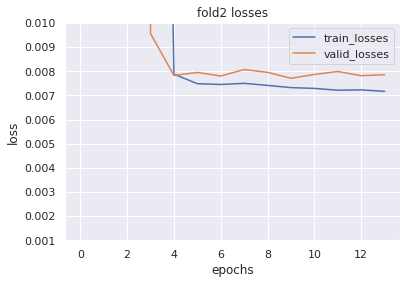

scored_loop
-----EPOCH1-----
train_loss: 0.63188, train_metric: 0.63178
valid_loss: 0.42291, valid_metric: 0.42257
-----EPOCH2-----
train_loss: 0.16826, train_metric: 0.16723
valid_loss: 0.04258, valid_metric: 0.04083
-----EPOCH3-----
train_loss: 0.02885, train_metric: 0.02666
valid_loss: 0.02260, valid_metric: 0.02002
-----EPOCH4-----
train_loss: 0.02182, train_metric: 0.01909
valid_loss: 0.02076, valid_metric: 0.01784
-----EPOCH5-----
train_loss: 0.02087, train_metric: 0.01791
valid_loss: 0.02061, valid_metric: 0.01753
-----EPOCH6-----
train_loss: 0.02073, train_metric: 0.01769
valid_loss: 0.02116, valid_metric: 0.01820
-----EPOCH7-----
train_loss: 0.02064, train_metric: 0.01758
valid_loss: 0.02079, valid_metric: 0.01767
-----EPOCH8-----
train_loss: 0.02080, train_metric: 0.01774
valid_loss: 0.02058, valid_metric: 0.01749
-----EPOCH9-----
train_loss: 0.02067, train_metric: 0.01762
valid_loss: 0.02073, valid_metric: 0.01769
-----EPOCH10-----
train_loss: 0.02076, train_metric: 0.01771


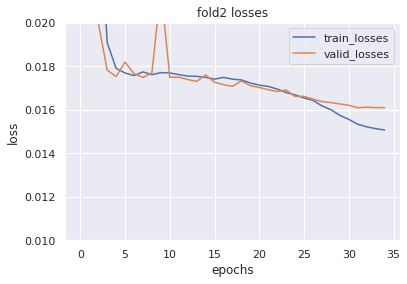

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72804, train_metric: 0.72804
valid_loss: 0.70167, valid_metric: 0.70166
-----EPOCH2-----
train_loss: 0.69396, train_metric: 0.69395
valid_loss: 0.67610, valid_metric: 0.67607
-----EPOCH3-----
train_loss: 0.52662, train_metric: 0.52642
valid_loss: 0.25119, valid_metric: 0.25056
-----EPOCH4-----
train_loss: 0.06508, train_metric: 0.06332
valid_loss: 0.01223, valid_metric: 0.00946
-----EPOCH5-----
train_loss: 0.01105, train_metric: 0.00792
valid_loss: 0.01094, valid_metric: 0.00766
-----EPOCH6-----
train_loss: 0.01073, train_metric: 0.00748
valid_loss: 0.01095, valid_metric: 0.00777
-----EPOCH7-----
train_loss: 0.01070, train_metric: 0.00750
valid_loss: 0.01097, valid_metric: 0.00786
-----EPOCH8-----
train_loss: 0.01065, train_metric: 0.00748
valid_loss: 0.01079, valid_metric: 0.00755
-----EPOCH9-----
train_loss: 0.01057, train_metric: 0.00740
valid_loss: 0.01077, valid_metric: 0.00753
-----EPOCH10-----
train_loss: 0.

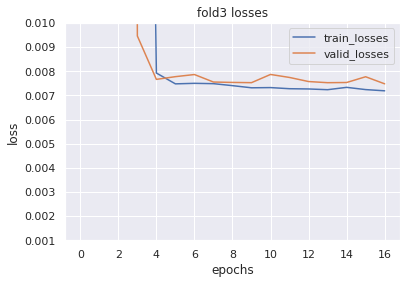

scored_loop
-----EPOCH1-----
train_loss: 0.61276, train_metric: 0.61265
valid_loss: 0.40409, valid_metric: 0.40372
-----EPOCH2-----
train_loss: 0.15834, train_metric: 0.15728
valid_loss: 0.04201, valid_metric: 0.04025
-----EPOCH3-----
train_loss: 0.02864, train_metric: 0.02645
valid_loss: 0.02253, valid_metric: 0.01989
-----EPOCH4-----
train_loss: 0.02183, train_metric: 0.01911
valid_loss: 0.02112, valid_metric: 0.01822
-----EPOCH5-----
train_loss: 0.02101, train_metric: 0.01807
valid_loss: 0.02074, valid_metric: 0.01776
-----EPOCH6-----
train_loss: 0.02081, train_metric: 0.01778
valid_loss: 0.02057, valid_metric: 0.01744
-----EPOCH7-----
train_loss: 0.02070, train_metric: 0.01765
valid_loss: 0.02069, valid_metric: 0.01744
-----EPOCH8-----
train_loss: 0.02069, train_metric: 0.01763
valid_loss: 0.02100, valid_metric: 0.01781
-----EPOCH9-----
train_loss: 0.02078, train_metric: 0.01773
valid_loss: 0.02054, valid_metric: 0.01742
-----EPOCH10-----
train_loss: 0.02069, train_metric: 0.01764


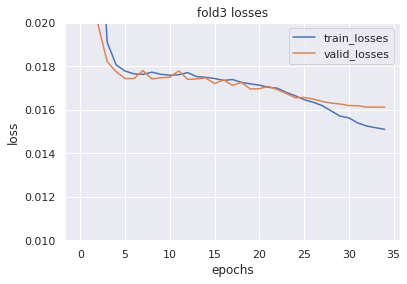

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72808, train_metric: 0.72808
valid_loss: 0.70175, valid_metric: 0.70174
-----EPOCH2-----
train_loss: 0.69409, train_metric: 0.69408
valid_loss: 0.67492, valid_metric: 0.67489
-----EPOCH3-----
train_loss: 0.52539, train_metric: 0.52518
valid_loss: 0.24201, valid_metric: 0.24135
-----EPOCH4-----
train_loss: 0.06409, train_metric: 0.06232
valid_loss: 0.01215, valid_metric: 0.00939
-----EPOCH5-----
train_loss: 0.01104, train_metric: 0.00792
valid_loss: 0.01077, valid_metric: 0.00750
-----EPOCH6-----
train_loss: 0.01077, train_metric: 0.00751
valid_loss: 0.01071, valid_metric: 0.00745
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00752
valid_loss: 0.01072, valid_metric: 0.00753
-----EPOCH8-----
train_loss: 0.01068, train_metric: 0.00751
valid_loss: 0.01069, valid_metric: 0.00751
-----EPOCH9-----
train_loss: 0.01062, train_metric: 0.00746
valid_loss: 0.01069, valid_metric: 0.00752
-----EPOCH10-----
train_loss: 0.

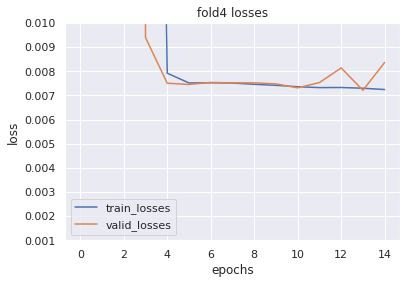

scored_loop
-----EPOCH1-----
train_loss: 0.63030, train_metric: 0.63020
valid_loss: 0.41450, valid_metric: 0.41414
-----EPOCH2-----
train_loss: 0.16522, train_metric: 0.16418
valid_loss: 0.04243, valid_metric: 0.04067
-----EPOCH3-----
train_loss: 0.02880, train_metric: 0.02661
valid_loss: 0.02243, valid_metric: 0.01982
-----EPOCH4-----
train_loss: 0.02189, train_metric: 0.01917
valid_loss: 0.02103, valid_metric: 0.01814
-----EPOCH5-----
train_loss: 0.02102, train_metric: 0.01807
valid_loss: 0.02082, valid_metric: 0.01784
-----EPOCH6-----
train_loss: 0.02073, train_metric: 0.01770
valid_loss: 0.02042, valid_metric: 0.01731
-----EPOCH7-----
train_loss: 0.02071, train_metric: 0.01765
valid_loss: 0.02047, valid_metric: 0.01742
-----EPOCH8-----
train_loss: 0.02078, train_metric: 0.01772
valid_loss: 0.02069, valid_metric: 0.01754
-----EPOCH9-----
train_loss: 0.02086, train_metric: 0.01781
valid_loss: 0.02068, valid_metric: 0.01756
-----EPOCH10-----
train_loss: 0.02070, train_metric: 0.01764


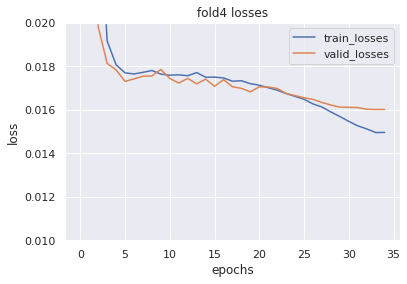

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72805, train_metric: 0.72805
valid_loss: 0.70162, valid_metric: 0.70162
-----EPOCH2-----
train_loss: 0.69415, train_metric: 0.69414
valid_loss: 0.67794, valid_metric: 0.67792
-----EPOCH3-----
train_loss: 0.52576, train_metric: 0.52555
valid_loss: 0.24746, valid_metric: 0.24682
-----EPOCH4-----
train_loss: 0.06463, train_metric: 0.06286
valid_loss: 0.01211, valid_metric: 0.00935
-----EPOCH5-----
train_loss: 0.01106, train_metric: 0.00793
valid_loss: 0.01071, valid_metric: 0.00743
-----EPOCH6-----
train_loss: 0.01078, train_metric: 0.00753
valid_loss: 0.01068, valid_metric: 0.00747
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00752
valid_loss: 0.01076, valid_metric: 0.00764
-----EPOCH8-----
train_loss: 0.01071, train_metric: 0.00754
valid_loss: 0.01063, valid_metric: 0.00745
-----EPOCH9-----
train_loss: 0.01067, train_metric: 0.00750
valid_loss: 0.01058, valid_metric: 0.00738
-----EPOCH10-----
train_loss: 0.

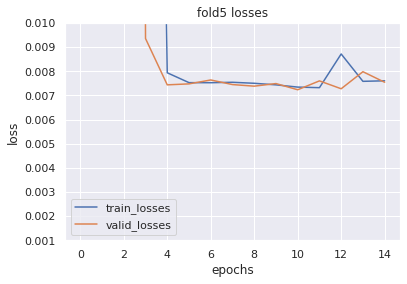

scored_loop
-----EPOCH1-----
train_loss: 0.63423, train_metric: 0.63415
valid_loss: 0.41570, valid_metric: 0.41535
-----EPOCH2-----
train_loss: 0.16752, train_metric: 0.16650
valid_loss: 0.04251, valid_metric: 0.04076
-----EPOCH3-----
train_loss: 0.02889, train_metric: 0.02671
valid_loss: 0.02324, valid_metric: 0.02072
-----EPOCH4-----
train_loss: 0.02191, train_metric: 0.01919
valid_loss: 0.02117, valid_metric: 0.01831
-----EPOCH5-----
train_loss: 0.02108, train_metric: 0.01813
valid_loss: 0.02123, valid_metric: 0.01807
-----EPOCH6-----
train_loss: 0.02083, train_metric: 0.01780
valid_loss: 0.02097, valid_metric: 0.01790
-----EPOCH7-----
train_loss: 0.02080, train_metric: 0.01775
valid_loss: 0.02099, valid_metric: 0.01801
-----EPOCH8-----
train_loss: 0.02091, train_metric: 0.01786
valid_loss: 0.02095, valid_metric: 0.01781
-----EPOCH9-----
train_loss: 0.02077, train_metric: 0.01772
valid_loss: 0.02093, valid_metric: 0.01784
-----EPOCH10-----
train_loss: 0.02080, train_metric: 0.01775


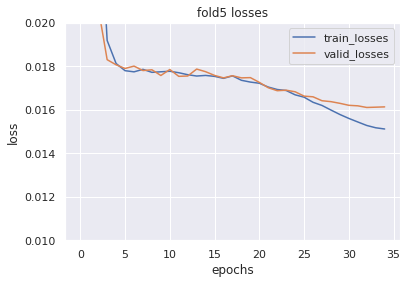

In [36]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))
CVs = list()

print(f'used device: {DEVICE}')

for seed in SEED:
    
    print(f' ')
    print(f'SEED : {seed}')
    print(f'')
    
    oof_, predictions_, CVs_ = run_k_fold(NFOLDS, seed, EPOCHS, LEARNING_RATE)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)
    CVs += CVs_
    
train[target_cols] = oof
test[target_cols] = predictions

In [37]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(
    train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

cv = 0
for i in range(len(target_cols)):
    cv_ = log_loss(y_true[:, i], y_pred[:, i])
    cv += cv_ / len(target_cols)
    
auc = 0
for i in range(len(target_cols)):
    auc_ = roc_auc_score(y_true[:, i], y_pred[:, i])
    auc += auc_ / len(target_cols)
    
print(f'CV log_loss: {cv:.6f} +/- {np.std(CVs):.6f}')
print(f'AUC: {auc:.6f}')

CV log_loss: 0.014814 +/- 0.000325
AUC: 0.815236


In [38]:
file_path = 'oof_ResNet.npy'
np.save(file_path, oof)

sub = sample_submission.drop(columns=target_cols).merge(
    test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [39]:
print(f'sample_submission.shape : {sample_submission.shape}')
print(f'sub.shape : {sub.shape}')

sample_submission.shape : (3982, 207)
sub.shape : (3982, 207)
